#Text Mining project
###Simeoni Ildebrando


The aim of this project is to leverage the descriptive text mining method on a new, unseen dataset.

The main contribution of this project are:

* showing how the aforementioned method can be easily reproduced and applied to different datasets
* presenting a more structured and easy to read framework, thanks to a more functional programming oriented structure of the notebook
* paving the way to more complex analysis by means of different way to generate the latent space (as can be seen in the project work notebook)
* experimenting with a statistical computing programming language like R and showing how to leverage it for text mining analysis








##Utilities

###Libraries
All the useful libraries and packages are installed

In [ ]:
install.packages("lsa")
install.packages("tm")
install.packages("RWeka")
install.packages('dplyr')
install.packages("stopwords")
library(dplyr)
library(tm)
library(lsa)
library(RWeka)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘SnowballC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ISOcodes’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: NLP

Loading required package: SnowballC



###Utility functions
Here all the useful functions that will be later called in the notebook are defined.
A short informative description of each function preceeds its definition even if in most cases function names are self explanatory

In [ ]:
#Function that allows the creation of the dataframe from a csv file loaded in COLAB local memory
dataframe_creation <- function(filename) {
  df <- read.csv(file = filename,  stringsAsFactors = FALSE)
  print(paste('Number of rows in the dataframe: ',nrow(df)))
  return(df)
}

#Function for the manipulation of the dataframe, selecting only the raw text column of the documens and the class column related to each document
dataframe_manipulation <- function(start_df, text_column, class_column){
  #Feature selection
  df <- subset(start_df, select = c(toString(text_column), toString(class_column)))
  #Removing duplicates in the text column
  df <- distinct(df, eval(as.symbol(text_column)), .keep_all = TRUE)
  df <- df[, -3]
  print(paste('Number of rows in the manipulated dataframe: ',nrow(df)))
  return(df)
}

#Function for the creation and normalization of the corpus (useful for the tdm) starting from a long text
corpus_creation <- function(text) {
  corpus_not_normalized <- Corpus(VectorSource(text))
  stoplist <- stopwords::stopwords("en")
  #Normalization process
  corpus <- tm_map( corpus_not_normalized, tolower )
  corpus <- tm_map( corpus, removePunctuation )
  corpus <- tm_map( corpus, removeWords, stoplist )
  #Sanity check
  if(length(corpus_not_normalized$content) != length(corpus$content)){
    print('Documents have been dropped during the corpus normalization process')
  }
  #Showing results of normalization
  print(corpus_not_normalized[[1]]$content)
  print(corpus[[1]]$content)
  return(corpus)
}

#Function for the creation of the term-document matrix and some manipulations/statistics over it
tdm_creation <- function(corpus){
  tdm <- TermDocumentMatrix(corpus)
  inspect(tdm[1:20, 1:20])
  #Removal of sparse terms being the tdm a sparse matrix, choosing the 98% most frequent terms
  tdm_not_sparse <- removeSparseTerms(tdm, 0.98)
  tdm <- as.matrix(tdm_not_sparse)
  #TF-IDF term weighting of the terms-docs matrix
  tdm <- lw_logtf(tdm) * (1-entropy(tdm))
  print(paste('Dimension of the term-document matrix: ',toString(dim(tdm))))
  return(tdm)
}

#Function to compute the norm of a vector
norm_vec <- function(x) sqrt(sum(x^2))

#Function to compute normalization of terms and docs vectors
normrows <- function(x) x / apply(x,1,norm,"2")

#Function that allows the creation of the latent space starting from a tdm
latent_space_creation <- function(tdm){
  lsa_space <- lsa(tdm)
  print(paste('The low rank choosen by R is: ',length(lsa_space$sk)))
  print('The graph of the eigenvalues computed by the SVD is the following')
  plot(1:length(lsa_space$sk),lsa_space$sk, type="b" )
  return(lsa_space)
}

#Function for the creation of the term matrix in the latent space
lsa_term_matrix_creation <- function(lsa_space){
  #Computing term matrix in the LSA space weighted by the eigenvalues
  lsa_term_matrix <- lsa_space$tk %*% diag(lsa_space$sk)
  #Computing the norm of each term in the lsa_term_matrix, the result is a vector
  lsa_terms_norm <- apply(lsa_term_matrix, 1, norm_vec)
  #Add one last column containing the norms to the terms computed before
  lsa_term_matrix_with_norm <- cbind(lsa_term_matrix, lsa_terms_norm)

  print('First graph: terms using the first two latent dimensions')
  print('Second graph: subset of terms with norm > 1.25')
  print('Third graph: terms using the second and third latent dimensions')

  #Graphic representation of terms using the first two latent dimensions
  options(repr.plot.width=16, repr.plot.height=14)
  plot(lsa_term_matrix, pch=20 )
  text(lsa_term_matrix, labels=words, cex=1.2, pos=1 )

  #Graphic representation of the terms with norm > 1.25 (the last column in the lsa_term_matrix_with_norm contains the norms) terms with lower norm are less relevant in LSA because the term is near the origin
  lsa_term_matrix_reduced <- subset(lsa_term_matrix_with_norm, lsa_terms_norm > 1.25)[,-(length(lsa_space$sk)+1)]
  options(repr.plot.width=14, repr.plot.height=12)
  plot( lsa_term_matrix_reduced, pch=21, cex=0.3 )
  text( lsa_term_matrix_reduced, labels=words, cex=1.3, pos=1 )

  #Graphic representation of terms using the second and third latent variables because the second and third eigenvalue are more similar so we get a more radial distribution
  options(repr.plot.width=14, repr.plot.height=12)
  #-1 removes the first latent dimensions in order to display 2° and 3°
  plot( lsa_term_matrix[,-1], pch=20 )
  text( lsa_term_matrix[,-1], labels=words, cex=1.2, pos=1 )
  points( 0, 0, pch=20, cex=3, col="red" )
  return(lsa_term_matrix) #o lsa_term_matrix_reduced ?
}

#Function for the creation of the document matrix in the latent space
lsa_document_matrix_creation <- function(lsa_space){
  #Computing document matrix in the LSA space weighted by the eigenvalues
  lsa_document_matrix <- lsa_space$dk %*% diag(lsa_space$sk)

  print('First graph: documents using the first two latent dimensions')
  print('Second graph: documents using the second and third latent dimensions')
  #Graphic representation of documents using the first two latent dimensions
  plot(lsa_document_matrix, pch=18, cex=0.8 )

  #Graphic representation of documents using the second and third latent dimensions
  plot( lsa_document_matrix[,-1], pch=18, cex=0.8 )
  return(lsa_document_matrix)
}

#Function that allows the visual inspection of the latent space by showing all the terms and documents in the new space
visual_inspection <- function(accidents, lsa_document_matrix, lsa_term_matrix){
  print(paste('Types of accidents in the dataset: ',toString(sort(unique(accidents)))))
  #Defining the colorcode for the severity of the accidents in the visual inspection
  damcols <- as.vector(recode(accidents, I = "green", II = "blue",  III = "yellow", IV = "orange", V = "red", VI = "purple"))

  #Graphic representation of the documents associated with their colored severity
  print('First graph: documents and their severity')
  print('Second graph: documents and terms normalized')
  options(repr.plot.width=15, repr.plot.height=13)
  plot(lsa_document_matrix[,-1], pch=10, cex=0.8, col=damcols)

  lsa_term_matrix_normalized <- normrows(lsa_term_matrix)
  lsa_document_matrix_normalized <- normrows(lsa_document_matrix)

  #Graphic representation of both vectors of terms and docs normalized
  options(repr.plot.width=18, repr.plot.height=16)
  plot( lsa_document_matrix_normalized[,-1], pch=20, cex=0.8, col=damcols )
  text( lsa_term_matrix_normalized[,-1], labels=words, cex=1.2 )
  points( 0, 0, pch=20, cex=5 )
}

#Function that allows to perform a chi-square test among a word and a class in order to check if those are correlated or not
test_one_word <- function(word,class,lsa_term_matrix){
  word_vs_class <- table(tdm[word,]>0, accidents==class)
  dimnames(word_vs_class) <- list(word = c("No", "Yes"), class = c("No", "Yes"))
  suppressWarnings(chisqtest <- chisq.test( word_vs_class, correct=FALSE ))
  #The chi-square test requires that the expected frequencies are all greater than 5, and that the table has no empty cells (with frequencies of 0)
  #Otherwise, the result may be unreliable.
  if(any(chisqtest$expected < 5)){
      print('Chi-squared test may be unreliable in this case')
    }
  else if (chisqtest$p.value < 0.05){
      print(chisqtest)
      print('List of the top 16 most correlated words to the one selected:')
      print(associate(lsa_term_matrix[,2:3], word, threshold=0.8)[1:16])
  }
  else {
    print('This word and this class are not correlated')
  }
}

#Function that allows to perform a chi-square test among two words and a class in order to check if those are correlated or not
test_two_words <- function(word1, word2 ,class,lsa_term_matrix){
  #Selecting all documents that contain both word1 and word2 and that belongs to specified class
  words_vs_class <- table(tdm[word1,]>0 & tdm[word2,]>0, accidents==class)
  #dimnames(words_vs_class) <- list(words = c("No", "Yes"), class = c("No", "Yes"))
  suppressWarnings(chisqtest <- chisq.test( words_vs_class, correct=FALSE ))
  if(any(chisqtest$expected < 5)){
      print('Chi-squared test may be unreliable in this case')
    }
  else if (chisqtest$p.value < 0.05){
      print(chisqtest)
  }
  else {
    print('This word and this class are not correlated')
  }
}


#Function that computes and shows the embedding of a query in the latent space
query_embedding <- function(word){
  query_one_hot <- query(word, words)
  query <- lw_logtf(query_one_hot) * (1-entropy(tdm))
  query <- t(query) %*% lsa_space$tk

  lsa_term_matrix_normalized <- normrows(lsa_term_matrix)
  lsa_document_matrix_normalized <- normrows(lsa_document_matrix)
  damcols <- as.vector(recode(accidents, I = "green", II = "blue",  III = "yellow", IV = "orange", V = "red", VI = "purple"))

  #Graphic representation of the terms, docs and our query in the LSA space using the dimensions 2 and 3
  print('First graph: terms, docs and query in the LSA space')
  plot( lsa_document_matrix_normalized[,-1], pch=20, cex=0.8, col=damcols )
  text( lsa_term_matrix_normalized[,-1], labels=words, cex=0.8 )
  points( 0, 0, pch=20, cex=3 )
  #Vector query normalization
  query_normalized <- normrows( query )
  points(query_normalized[2],query_normalized[3],cex=3,pch=18,col="blue")
  return(query)
}

#Function that computes cosine similarities among vector Q and X rows
cosines <- function(X, Q) apply( X, 1, cosine, as.vector(Q))

#Function that return the indices of the N highest value of X
top <- function(X, N) order( X, decreasing=TRUE )[1:N]

#Function that retrieves the top 5 most semantically similar documents to the query according to the LSA dimensions specified
document_retrieval <- function(query1, num_dim1, num_dim2){
  print(top(cosines(lsa_document_matrix[,num_dim1:num_dim2], query1[num_dim1:num_dim2] ),5))
  descriptions[top(cosines(lsa_document_matrix[,num_dim1:num_dim2], query1[num_dim1:num_dim2]), 5)]
}

#Function that plots the loss of information related to the eigenvalues choosen in the LSA space
eigenvalues_plot <- function(){
  fordiff <- function(x) x[2:length(x)] - x[1:(length(x)-1)]
  skd <- fordiff(lsa_space$sk)
  skdd <- fordiff(skd)
  skcurv <- skdd[1:20] / (1+(skd[1:20])^2)^1.5
  print('Information loss with respect to choosen eigenvalues ')
  plot( 1:20, skcurv, type="b" )
}

#Function that compute semantic analysis in the LSA space, to evaluate if there exists SEMANTIC correlation between a query and a class
semantic_correlation <- function(class, num_dim1, num_dim2, k, query){
  print(table(accidents[top(cosines(lsa_document_matrix[,num_dim1:num_dim2], query[num_dim1:num_dim2]), 10)]))
  print(table( accidents ))
  print(table( accidents[ top( cosines( lsa_document_matrix[,num_dim1:num_dim2], query[num_dim1:num_dim2] ), k ) ] ))
  query_vs_class <- table(1:nrow(lsa_document_matrix) %in% top(cosines(lsa_document_matrix[,num_dim1:num_dim2], query[num_dim1:num_dim2]), k), accidents == class )
  dimnames(query_vs_class) <- list(query = c("No", "Yes"), class = c("No", "Yes"))
  return(query_vs_class)
}

#Function that shows how incidents class are distributed in a semantic search results with respect to the query
semantic_search <- function(num_dim1, num_dim2, class){
  nearest <- sort( cosines( lsa_document_matrix[,num_dim1:num_dim2], query[num_dim1:num_dim2] ), decreasing=T )
  #Create a lists with 3229 times the word black
  damcols2 <- rep( "black", 3229 )
  #Define as red dots the one retrieved with class equal to 'class'
  damcols2[ accidents== class ] <- "red"
  plot( 1:top_k, nearest[1:top_k], pch=20, cex=0.7, col=damcols2[strtoi(names(nearest))] )
}

#Function that computes the semantic similarity among all the terms and our current query
semantic_similarity <- function(num_dim1, num_dim2, norm_threshold, query){
  terms <- lsa_space$tk %*% diag( sqrt( lsa_space$sk ) )
  query2 <- query %*% diag( lsa_space$sk^-0.5 )
  lsa_term_matrix_normalized <- apply( lsa_term_matrix[,num_dim1:num_dim2], 1, norm, "2" )
  print(sort(lsa_term_matrix_normalized[cosines(terms[,num_dim1:num_dim2],query2[num_dim1:num_dim2])>norm_threshold]))
}

##Code

###Data
The dataset used for this project is a free to use, public kaggle dataset accessible via this link: https://www.kaggle.com/datasets/ihmstefanini/industrial-safety-and-health-analytics-database.

The reason why the aforementioned dataset has been selected is that there is an urgent need for companies to understand why employees still suffer some injuries/accidents (sometimes fatal) in plants. So, the descriptive mining method has been adopted to explore the data and to try let new insights emerge.

The dataset contains 425 records of accidents from 12 different real-world manufacturing plants, located in 3 different countries. Every line in the data is an occurrence of an accident.

A short columns description is here presented:
*  Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymized)
* Local: the city where the manufacturing plant is located (anonymized)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
* Genre: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.






####Dataframe creation and manipulation
In this first section the dataset is loaded and then manipulated into an appropriate dataframe format, in order to be readable and easily transformable.

In [ ]:
filename <- '/content/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv'
starting_df <- dataframe_creation(filename)
head(starting_df,3)

[1] "Number of rows in the dataframe:  425"


,X,Data,Countries,Local,Industry.Sector,Accident.Level,Potential.Accident.Level,Genre,Employee.or.Third.Party,Critical.Risk,Description
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
2,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."
3,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury."


After having obtained and visualized the dataframe, a manipulation step occurs.
In particular, among all the columns present in the original dataframe only the interesting ones for our text mining purpose are kept, namely the raw text column (i.e. Description) and a class column.

For the choice of the class column, two of the original ones could have been selected, namely: Accident Level and Potential Accident Level. After a careful inspection of both of them I decided to consider the last one (i.e. Potential Accident Level) for two main reasons:
* from a techincal point of view, the Accident Level column was way more unbalanced than the Potential Accident Level one, being the majority of the samples (luckly) classified as of low level severity, letting me no chance to further investigate on higher severity accidents due to scarcity of documents realated
* from an analytical point of view, the Potential Accident Column allowed for more interesting insights being it related also to other factors in the dataframe that I discarded in the first phase

In [ ]:
df <- dataframe_manipulation(starting_df, 'Description', 'Potential.Accident.Level')
head(df,3)

[1] "Number of rows in the manipulated dataframe:  411"


,Description,Potential.Accident.Level
,<chr>,<chr>
1,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",IV
2,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",IV
3,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",III


The class attribute and the raw text are stored for successive uses

In [ ]:
accidents <- df$Potential.Accident.Level;
descriptions <- df$Description;

###Term-document matrix creation
The following block of cells lead to the creation of the terms-documents matrix from the raw technical report texts.

Starting from corpus creation via the raw texts, we define and apply a normalization process to remove all the not interesting terms from our analysis; this process is composed of: lowercasing the texts, removing punctuation, removing stop words and checking if during this process some documens have been dropped

In [ ]:
corpus <- corpus_creation(descriptions)

Warning message in tm_map.SimpleCorpus(corpus_not_normalized, tolower):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stoplist):
“transformation drops documents”


[1] "While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
[1] " removing  drill rod   jumbo 08  maintenance  supervisor proceeds  loosen  support   intermediate centralizer  facilitate  removal seeing   mechanic supports one end   drill   equipment  pull   hands  bar  accelerate  removal     moment  bar slides   point  support  tightens  fingers   mechanic   drilling bar   beam   jumbo"


Being the resulting term document matrix a very sparse matrix, a sparse term removal is applied, in particular all the terms with a frequency in documents lower than 2% are eliminated.

In [ ]:
tdm <- tdm_creation(corpus)
words <- rownames(tdm)

<<TermDocumentMatrix (terms: 20, documents: 20)>>
Non-/sparse entries: 33/367
Sparsity           : 92%
Maximal term length: 12
Weighting          : term frequency (tf)
Sample             :
           Docs
Terms       1 10 14 17 19 2 3 4 5 8
  bar       3  0  0  0  0 0 0 0 0 0
  drill     2  0  0  0  0 0 0 0 0 0
  drilling  1  0  0  1  0 0 0 0 0 0
  end       1  0  0  3  1 0 0 0 0 0
  equipment 1  0  1  1  0 0 0 0 0 0
  jumbo     2  0  1  0  0 0 0 0 0 0
  loosen    1  0  0  0  0 0 0 0 1 0
  mechanic  2  0  0  0  0 0 0 0 0 1
  moment    1  1  0  1  0 0 0 0 0 0
  one       1  0  0  1  1 0 0 0 0 0
[1] "Dimension of the term-document matrix:  279, 411"



Then a TF-IDF term reweighting of the terms-docs matrix is performed, and the final result is here shown

In [ ]:
head(tdm)

,1,2,3,4,5,6,7,8,9,10,⋯,402,403,404,405,406,407,408,409,410,411
bar,0.9284587,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
drill,0.6085648,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
drilling,0.3695632,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
end,0.3500404,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
equipment,0.2417083,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.4834167,0,0,0,0,0
hands,0.3812674,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0


###LSA space
In this block of cells the latent space is computed via LSA and all the matrices are shown in the new space

Having computed the SVD decomposition both the low rank choosen by R and the eigenvalues are shown

[1] "The low rank choosen by R is:  79"
[1] "The graph of the eigenvalues computed by the SVD is the following"


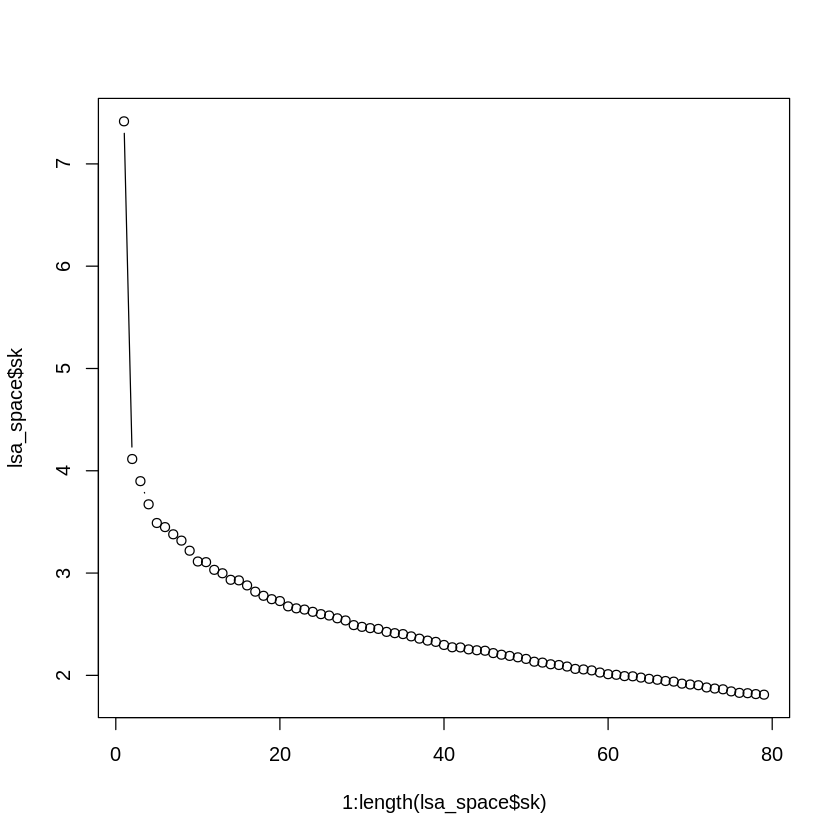

In [ ]:
lsa_space <- latent_space_creation(tdm)

Then terms and docs matrices are weighted by the eigenvalues because we can no longer compute similarity between objects without considering the sigma matrix, otherwise we wouldn't take in consideration the different importance in the dimensions.

Here follow some useful graphic representations, namely:


1.   Terms in the latent semantic space projected using the first two latent dimensions
2.   Subset of terms with norm greater than 1.25, because terms with lower norm are less relevant in LSA because the term is near the origin, while most informative terms are far away from it
3. Terms using the second and third latent dimensions, this is done because the second and third eigenvalue are more similar so we get a more radial distribution of terms, as can be appreciated in the image, in order to avoid that one direction compress the other one. A similar trend can be spotted also in the graphic representation of the lsa document matrix



[1] "First graph: terms using the first two latent dimensions"
[1] "Second graph: subset of terms with norm > 1.25"
[1] "Third graph: terms using the second and third latent dimensions"


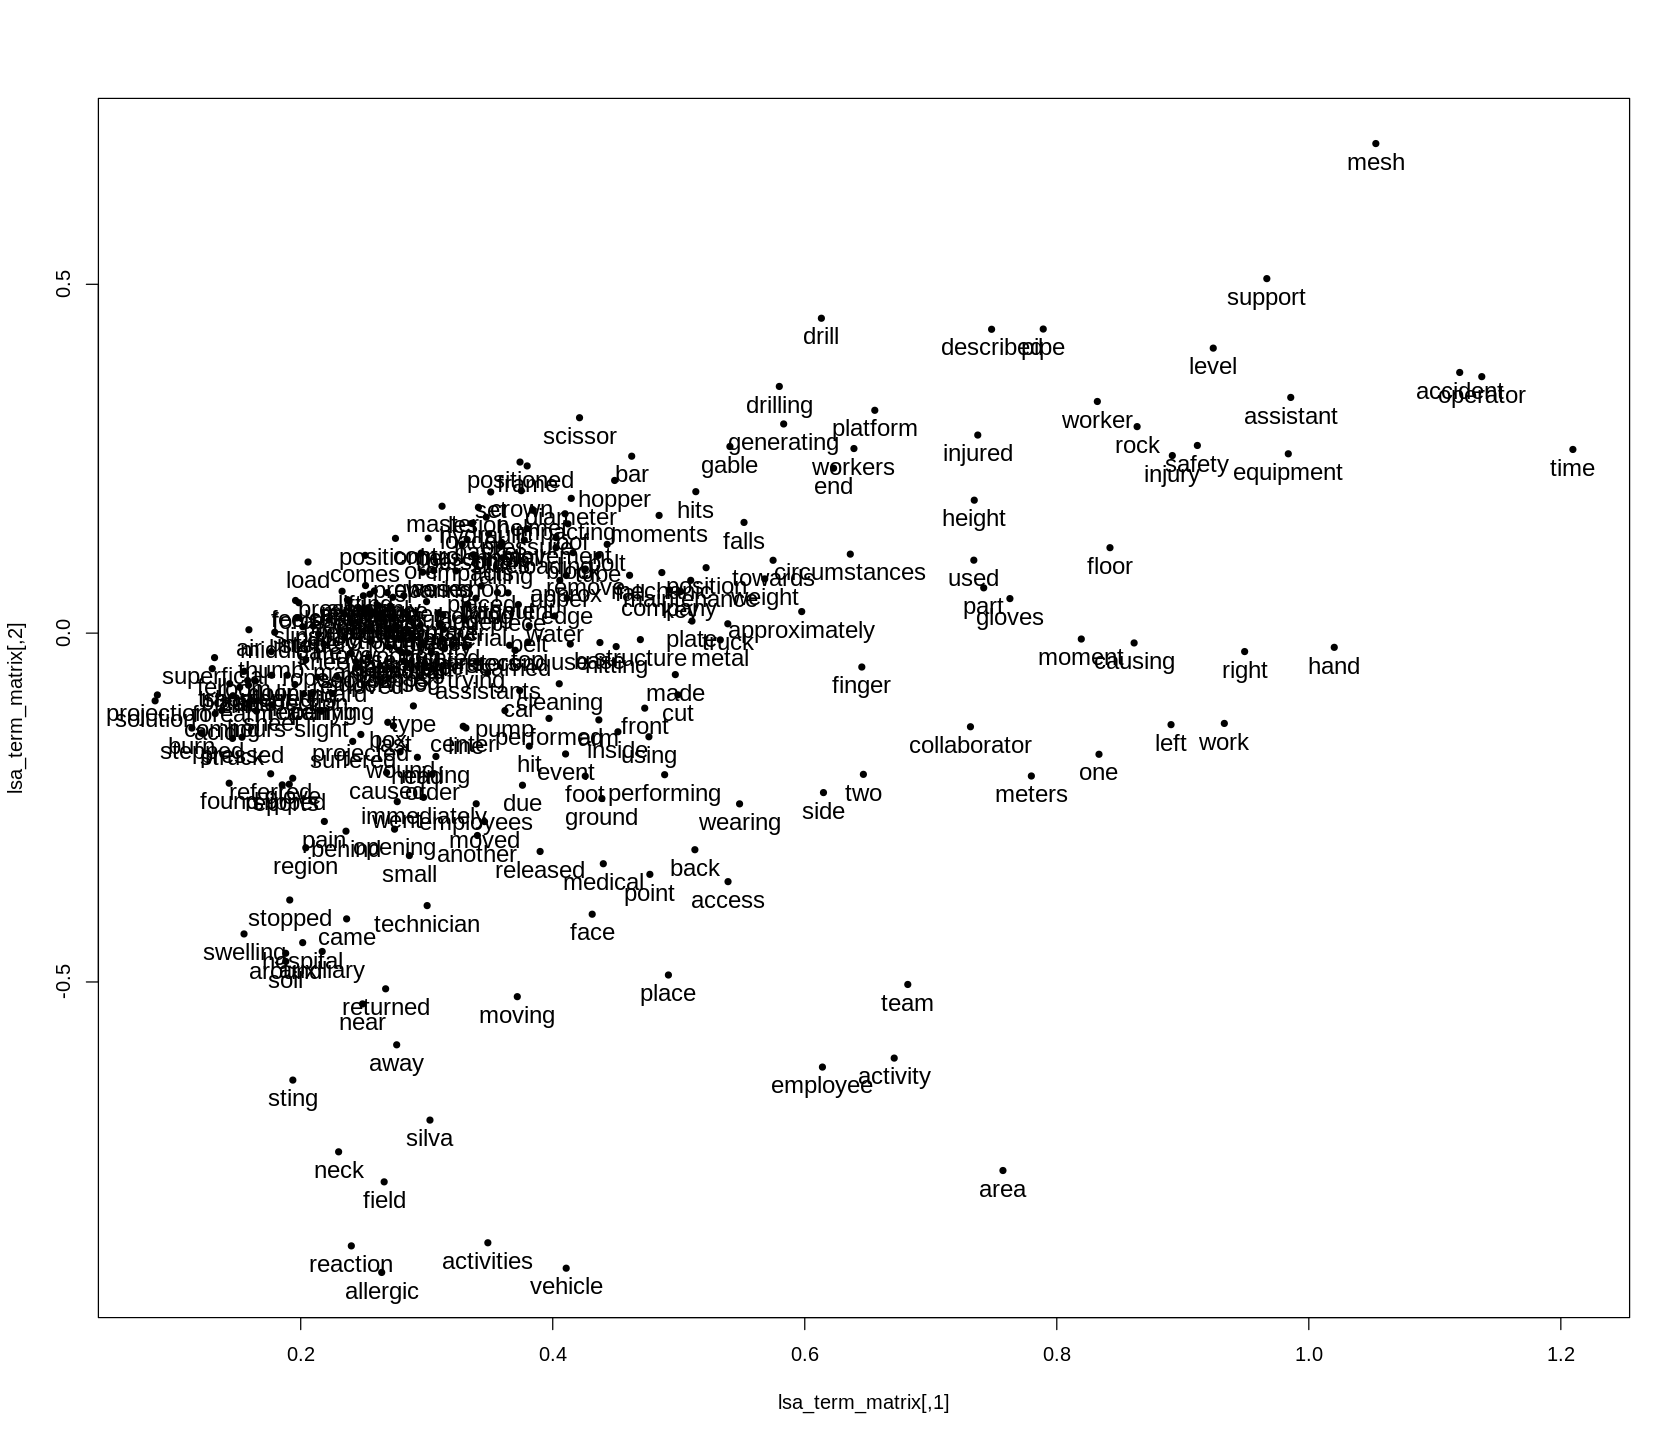

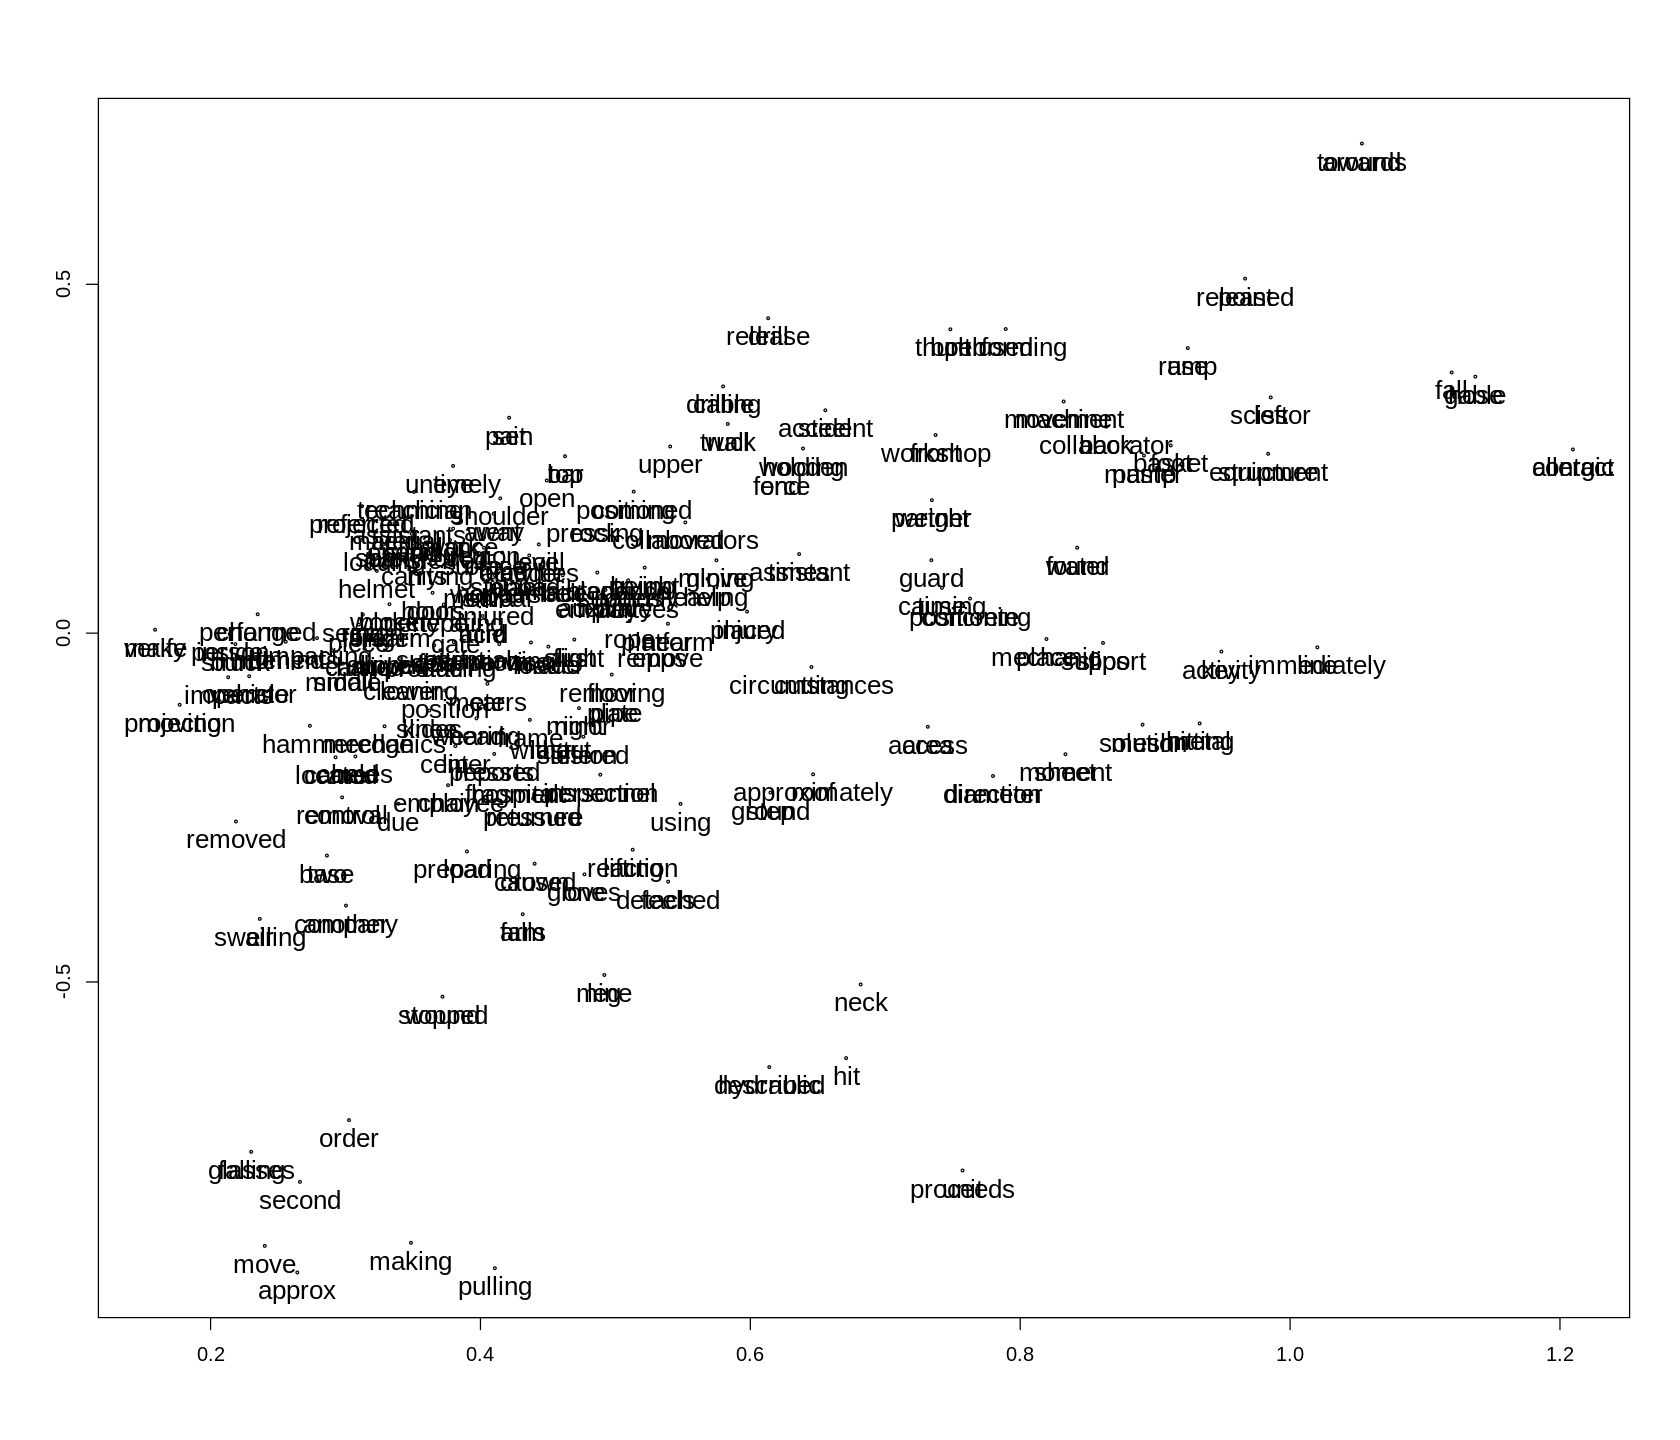

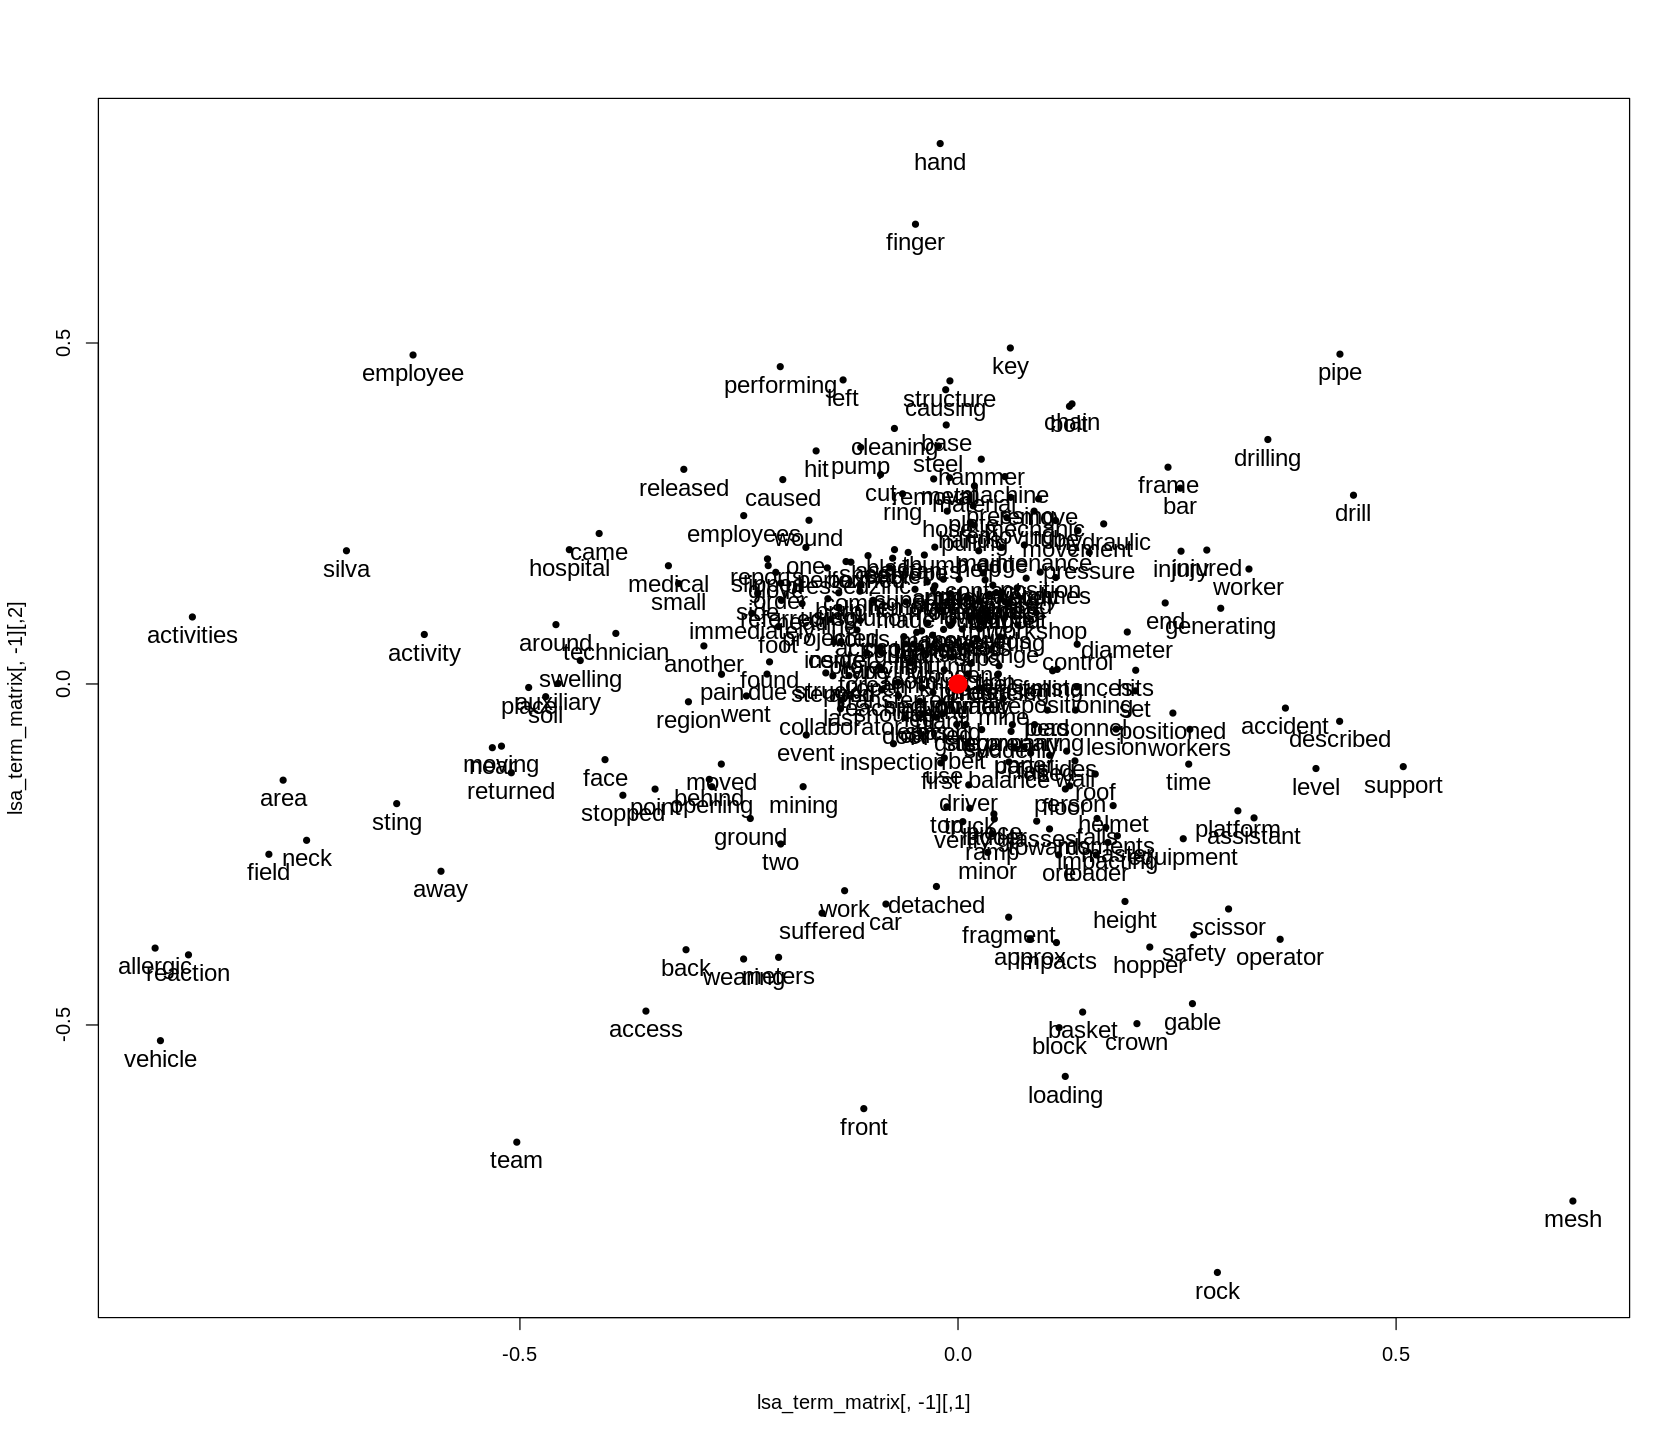

In [ ]:
lsa_term_matrix <- lsa_term_matrix_creation(lsa_space)

[1] "First graph: documents using the first two latent dimensions"
[1] "Second graph: documents using the second and third latent dimensions"


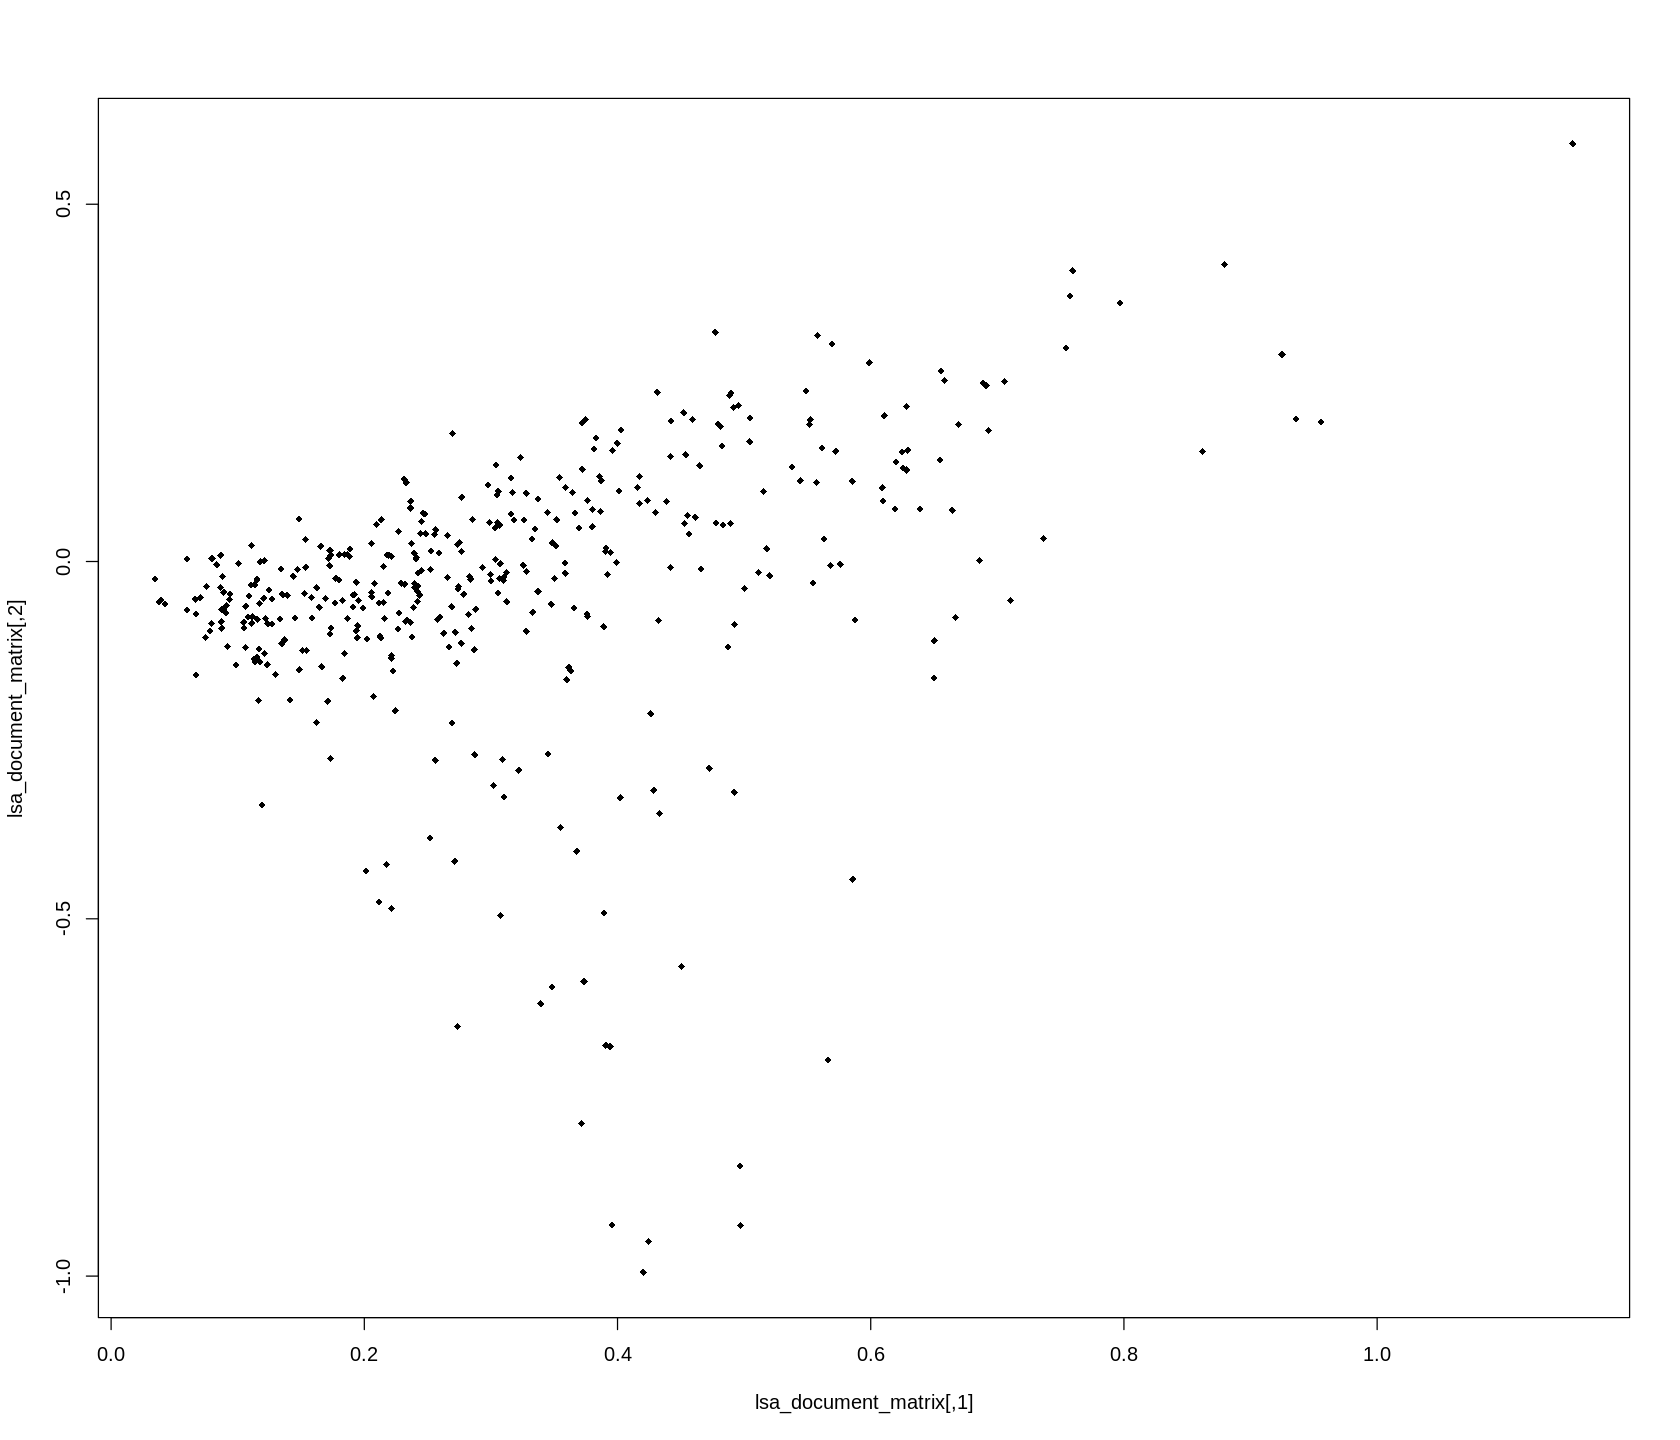

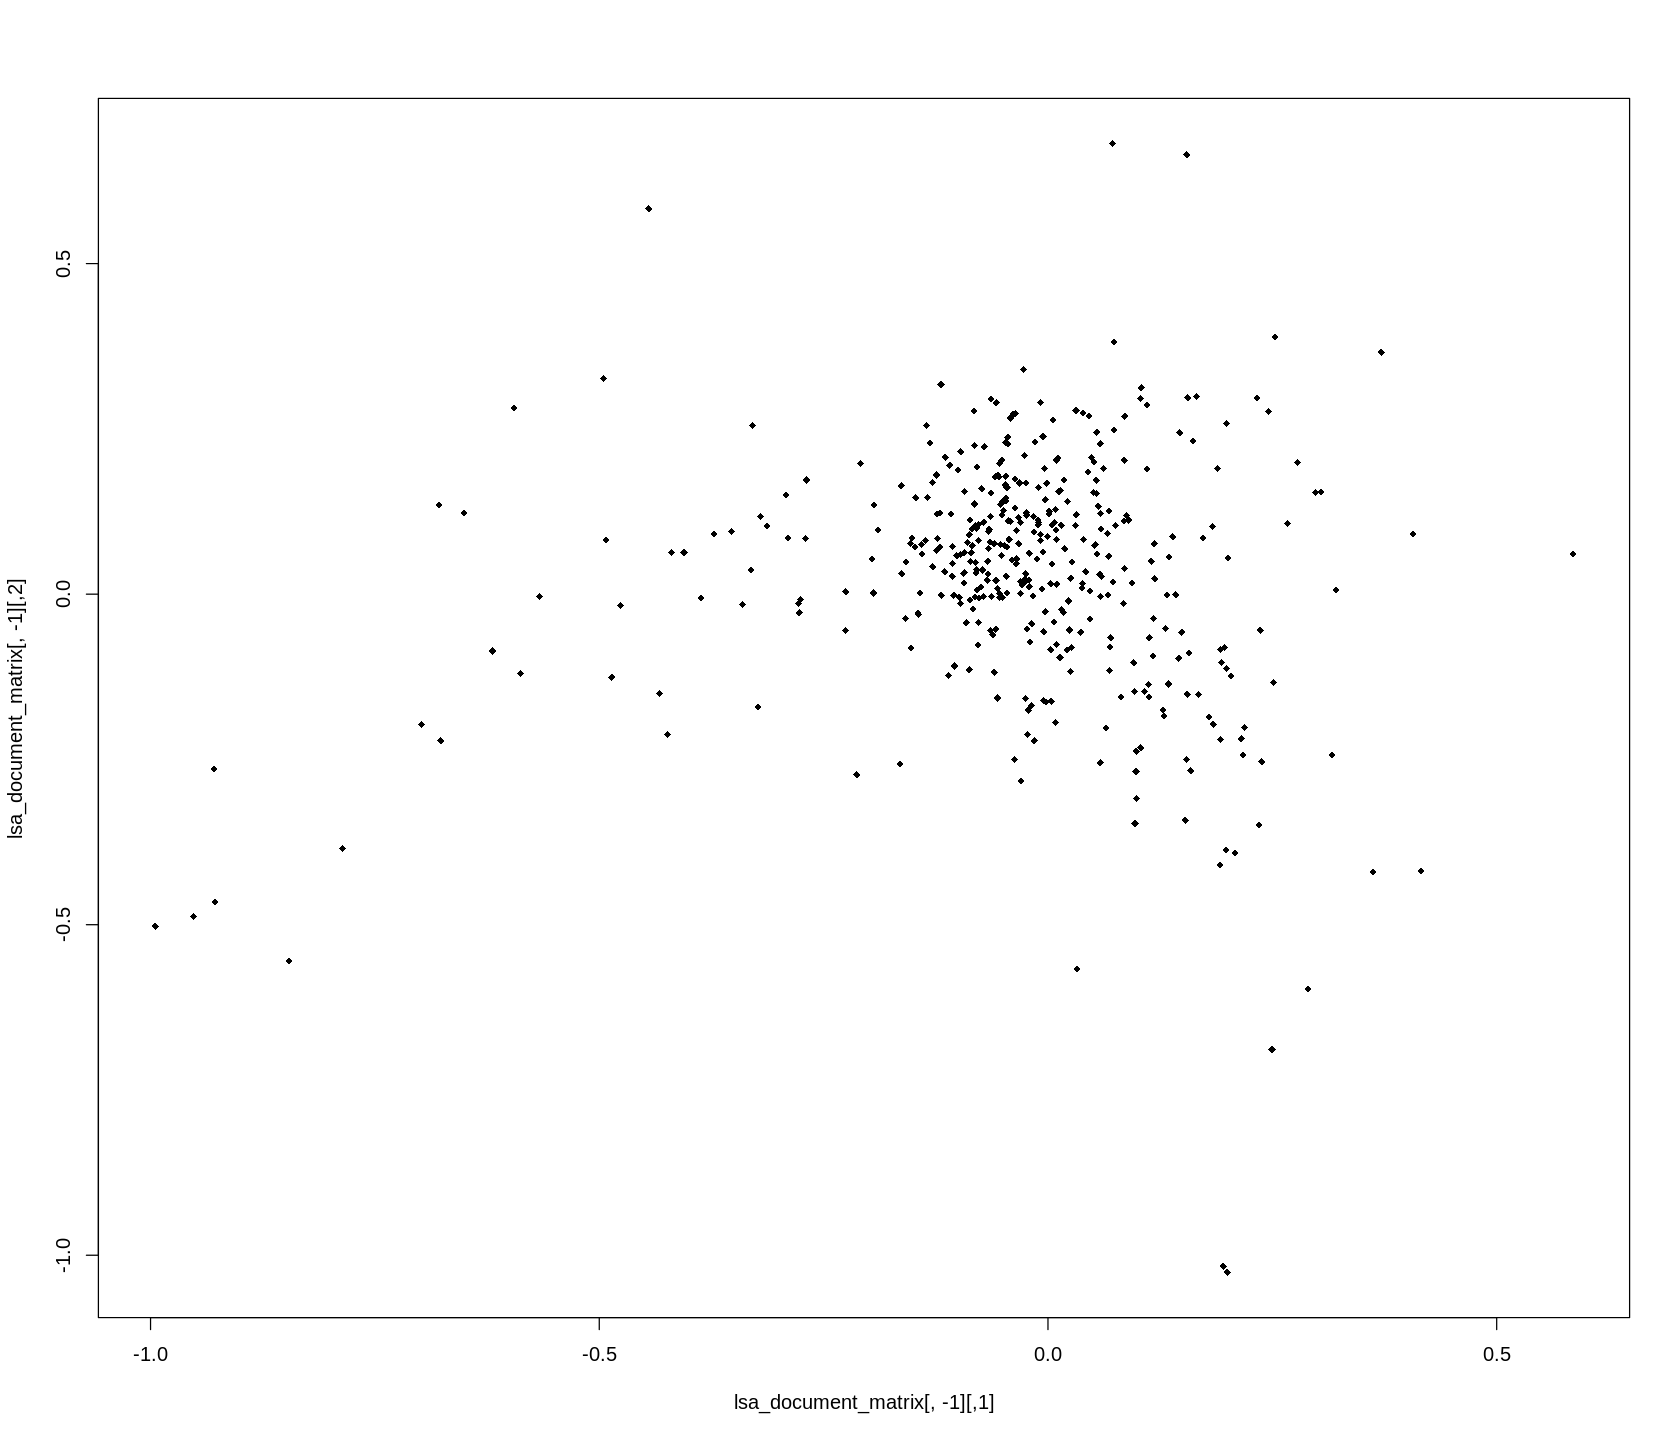

In [ ]:
lsa_document_matrix <- lsa_document_matrix_creation(lsa_space)

###Visual inspection
After having labeled the documents in the latent semantic space accordingly to their accident level class and plotted them togheter with the terms distribution, a visual inspection is performed in order to spot possible interesting areas of analysis

For the aim of this project more attention has been paid to investigate higher level risks accidents, being those the most interesting ones in terms of analysis and prediction in the real world; in particular, being the ones classificated as V or VI way more rare than the others I decided to focus more on IV and III types of incidents.

We should expect all the classes being equally distributed along the directions, but, as can be seen in the first graph, the orange class (i.e. IV accidents) is concentrated in the top right part of the graph, so that could be a first analysis direction to evaluate

[1] "Types of accidents in the dataset:  I, II, III, IV, V, VI"
[1] "First graph: documents and their severity"
[1] "Second graph: documents and terms normalized"


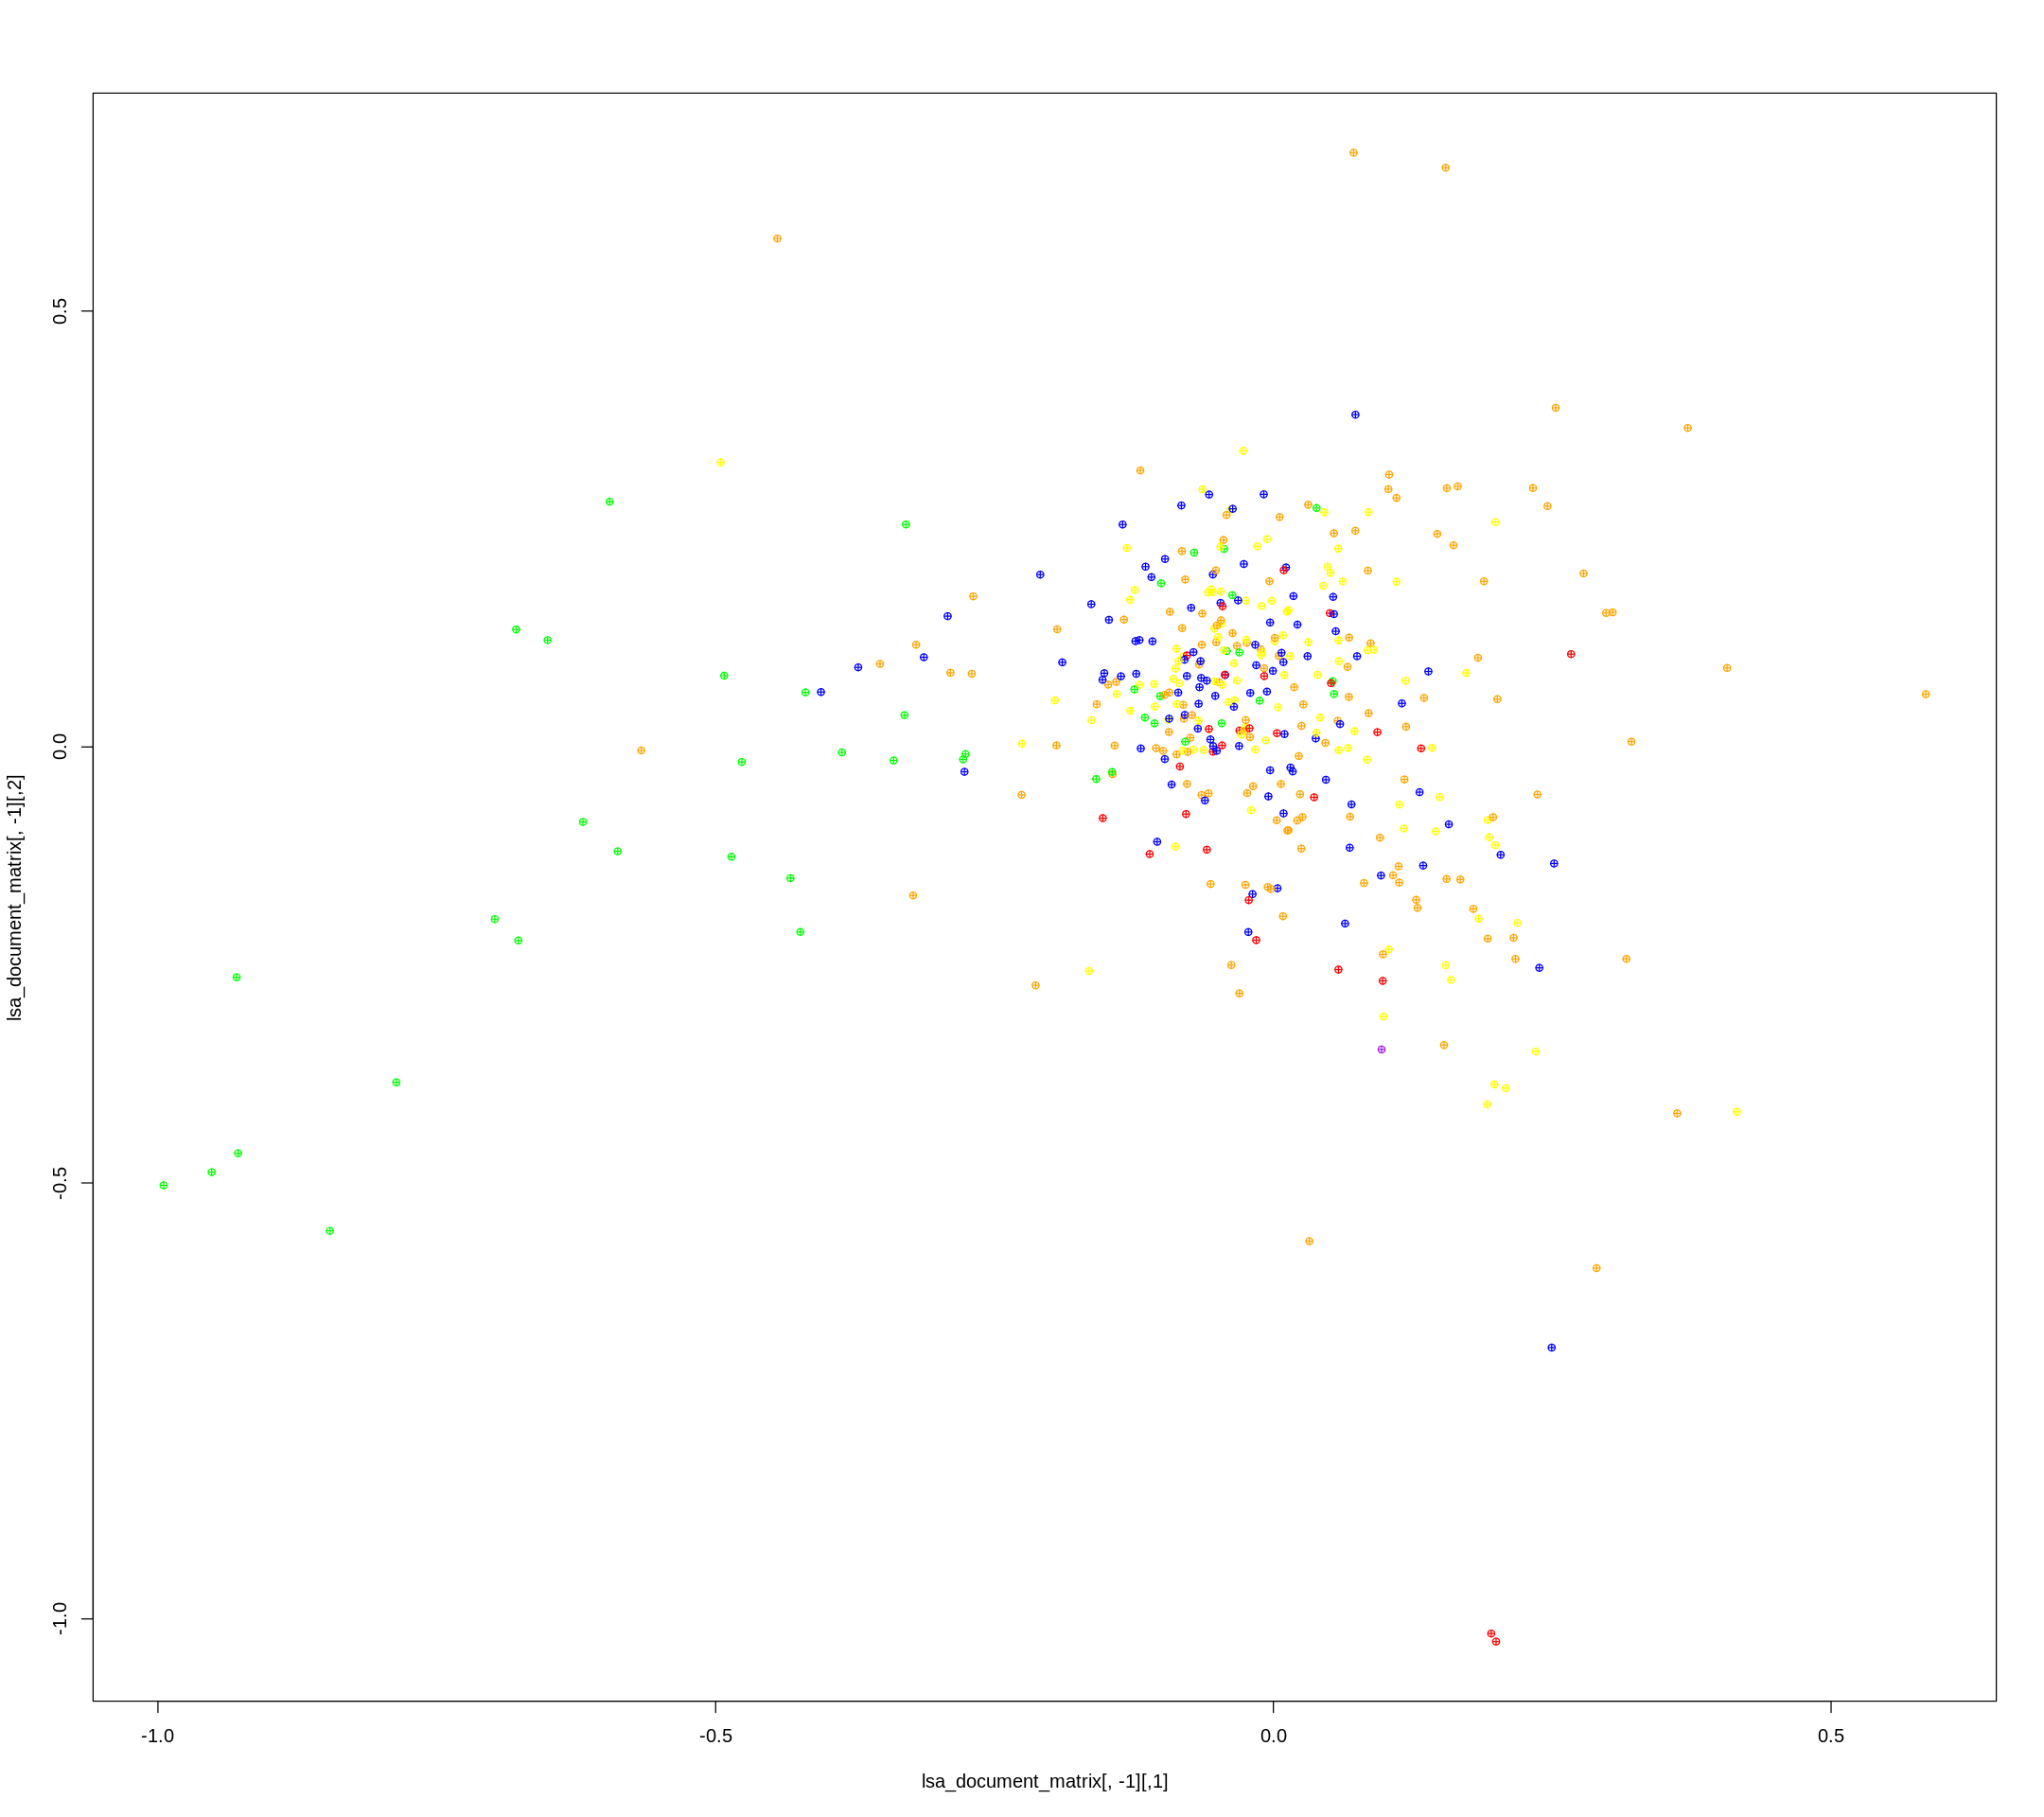

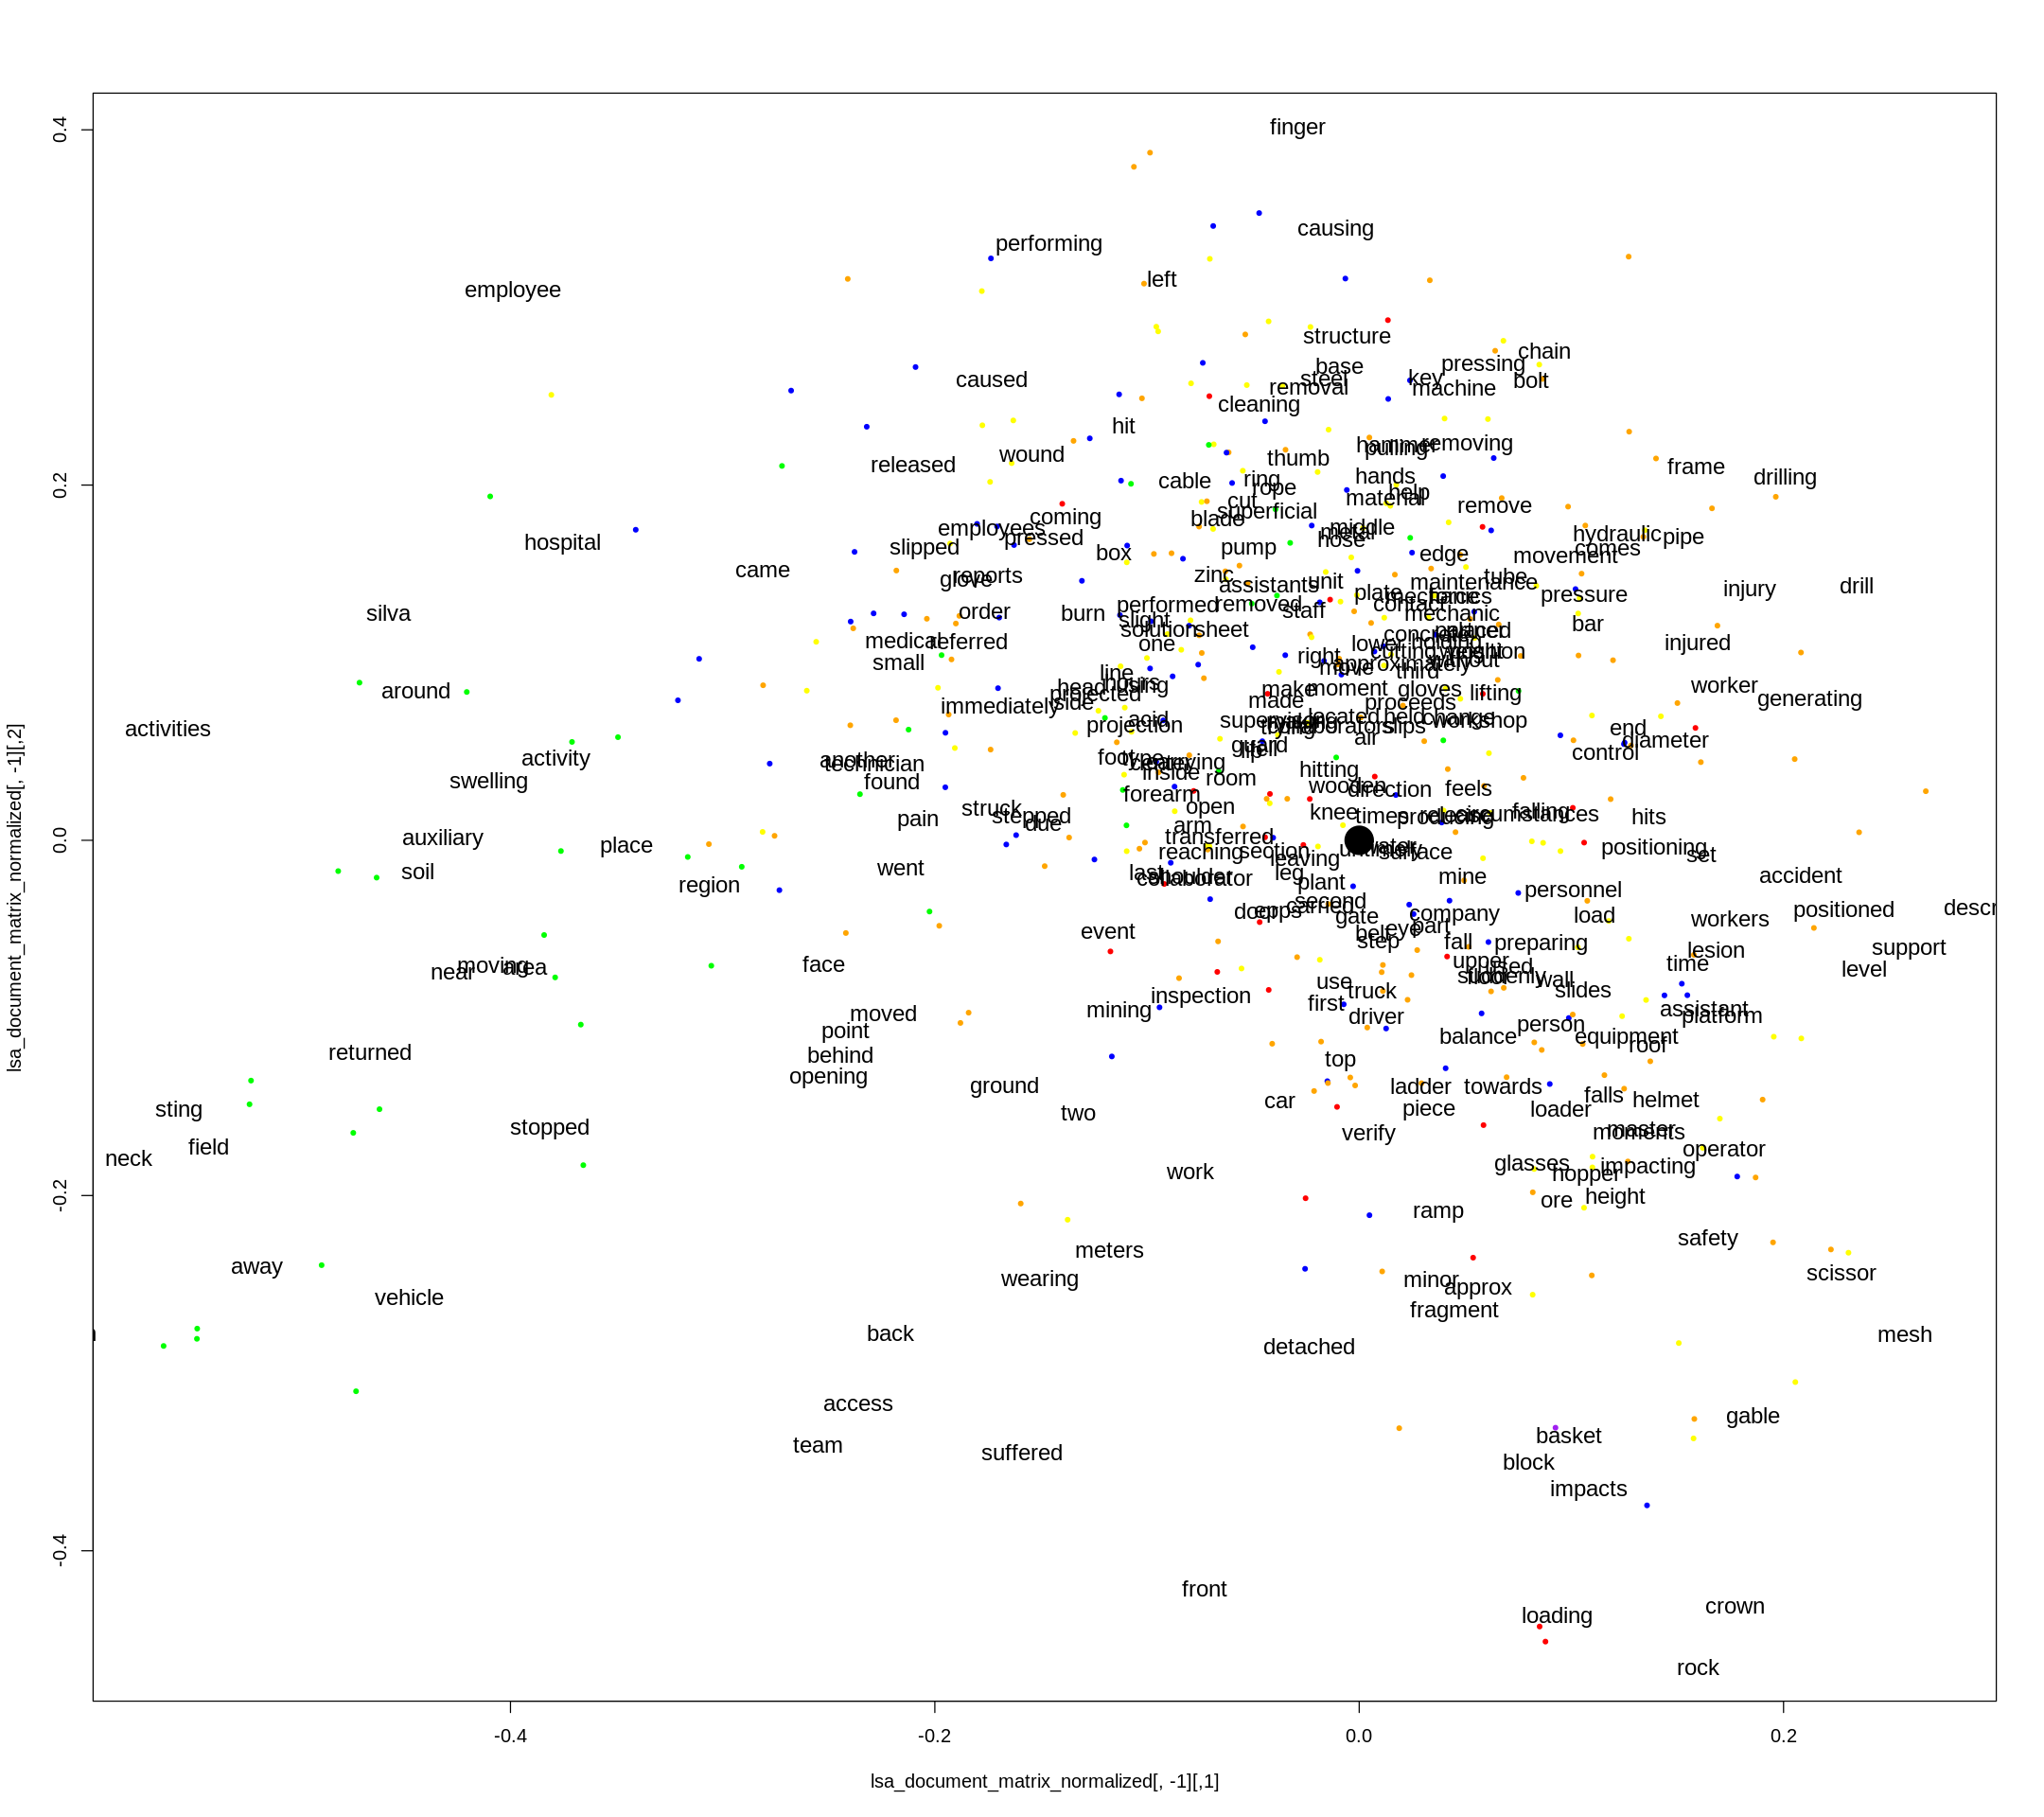

In [ ]:
visual_inspection(accidents, lsa_document_matrix, lsa_term_matrix)

###Chi square tests
All the hypotesis formulated after a visual inspection are here tested using the Chi square test, a statistical hypothesis test used to verify the independence between two events A and B

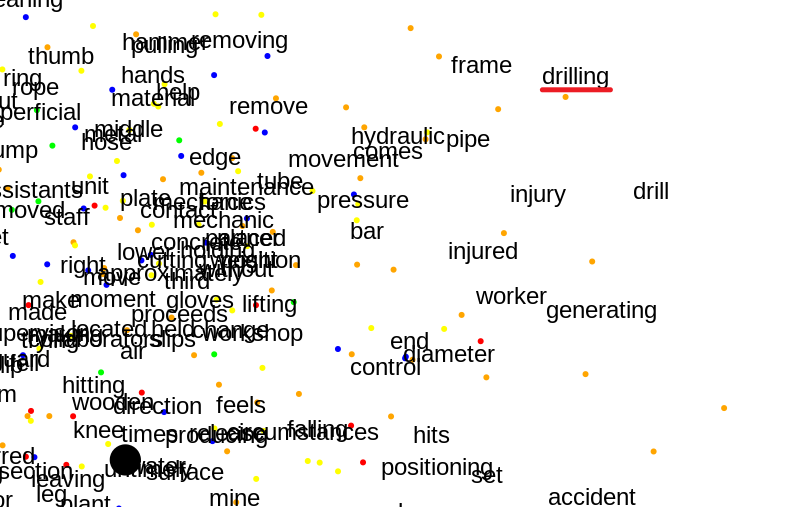

As it can be seen from the image above, the term **drilling** appears in the LSA space near an area with unusual concentration of level IV accidents; so this could be a good first candidate for our analysis. In the following cell the objectively verification of the existence of a lexical correlation between that term and the class IV of accidents is performed.

This verification is done in the original space (not in the latent semantic one).

In [ ]:
word1 <- 'drilling'
class <- 'IV'
test_one_word (word1, class, lsa_term_matrix)


	Pearson's Chi-squared test

data:  word_vs_class
X-squared = 16.49, df = 1, p-value = 4.89e-05

[1] "List of the top 16 most correlated words to the one selected:"
     pipe       bar  workshop   lifting  pressure     times     frame    injury 
0.9989848 0.9984855 0.9974524 0.9937965 0.9930709 0.9921708 0.9912331 0.9903229 
    comes hydraulic    change   injured  movement     drill  position     feels 
0.9875010 0.9868428 0.9850881 0.9825332 0.9732847 0.9708263 0.9666486 0.9623690 


The resulted p-value is very small, that means that the null hypotesis (namely that the term drilling and the class IV are not correlated) is rejected with an 99.995% confidence, so the term drilling is highly correlated with the accident class IV.

Other than that, the previous function also computed a list of the most semantically correlated words to the one analyzed (the semantic correlation is computed in the lsa space considering the second and third eigenvalues).

Most of the previous words have been discarded, because the chi-square test requires that the expected frequencies are all greater than 5, and that the table has no empty cells (with frequencies of 0) otherwise the result may be unreliable.

In order to avoid relying on an exact test, all the unreliable results have been discarded, leaving one most promising word which is **workshop**.
The Chi-square test performed in the folowing cell supports the hypothesis that the couple of terms **drilling worksop** is syntactically related to the accident class IV.

In [ ]:
word2 <- 'workshop'
test_two_words(word1, word2, class, lsa_term_matrix)


	Chi-squared test for given probabilities

data:  words_vs_class
X-squared = 44.343, df = 1, p-value = 2.756e-11



Up to now our analysis was only based on a syntactical level of similarity, not on a semantic one.

So now the same analysis is performed in the LSA space, to check if also a semantic correlation between the couple of terms **drilling workshop** and the IV accidents occurs.

In this case the considered docs could also not contain the two terms, but they may contain semantically correlated terms to them.
To peform this analysis the query has been transformed into document and then folded into the LSA space via the query_embedding function


As can be observed in the following cell, our query (displayed in blue) is aligned (i.e. has the highest cosine similarity) with the words **drilling** and **workshop**

[1] "First graph: terms, docs and query in the LSA space"


DRILLING WORKSHOP,0.0467563,0.04037937,0.04470966,-0.07018517,0.05257437,-0.0367962,0.02863967,0.03296133,0.04799003,-0.006919382,⋯,-0.01589538,0.005146932,-0.06270127,0.004814621,-0.05482336,0.001956439,0.04943091,0.005456391,-0.04955316,0.001042041


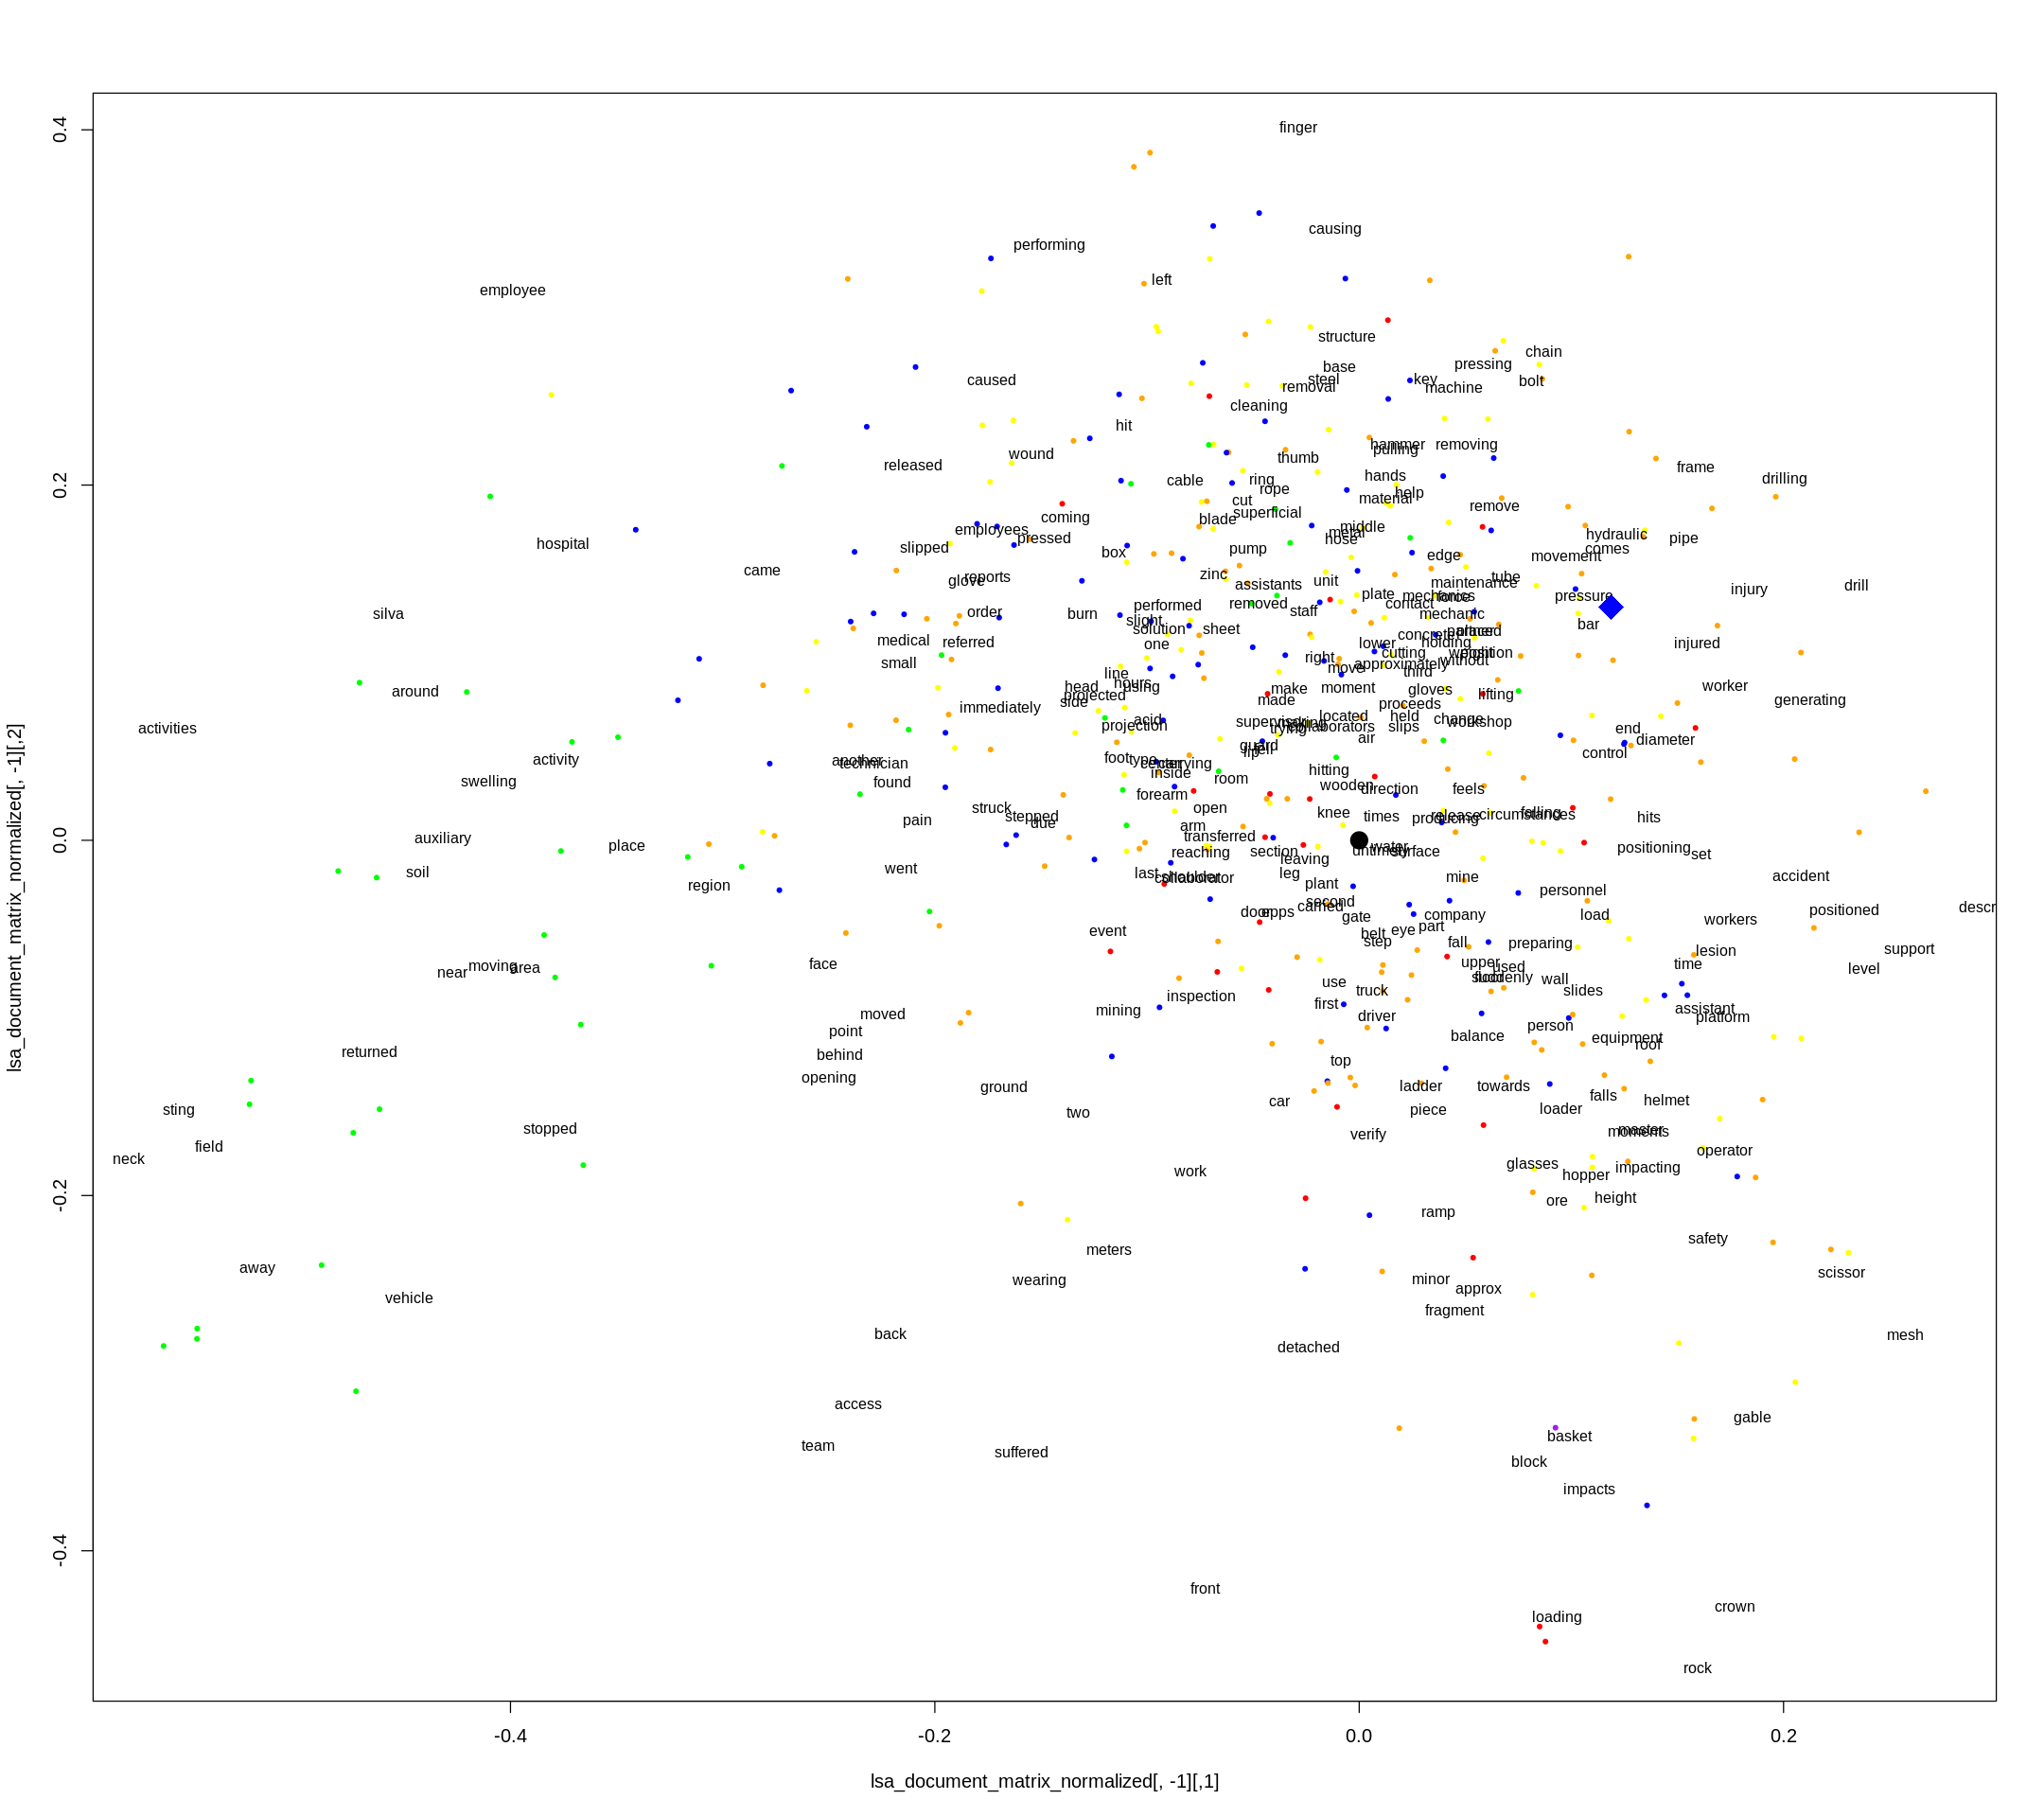

In [ ]:
sentence <- paste(word1, word2, sep =" ")
query <- query_embedding(sentence)
query

Then, indices and contents of the top 5 most semantically relevant documents with respect to our query are shown.

As we can see, with just two latent dimensions (arguments of the below function are the latent dimension indices) we obtain also documents not related with the drilling workshop query (e.g. the 254 one), this means that with just two latent dimensions we have a too high information loss.

In [ ]:
document_retrieval(query, 2, 3)

[1] 254 104  22 406  17


[1] "in Level 2900 dining room, the collaborator finished washing tabolas (food containers) of dimensions 52 cm x 30 cm x 20 cm, proceed to order them by pinking the thumb of the right hand in the corner of the aluminum tabola, generating the lesion. The employee at the time of the accident did not have safety gloves."                                                                                                                                                                                                                                                                                                                                                                                             
[2] "In the DDH chamber of the company Explomin, located at the level -100 Socorro ramp 334, when the worker - assistant driller-was dismantling the fifth drill rod (NQ - 3 meters of steel with a weight of 24 kg) , using a stilson key (No. 18), at that moment the operator operates the rotation unit, the drill rod rotates by pressing the left hand of the worker against the base of the rod holder, causing an injury to the left hand. At the time of the accident, the drilling assistant used rubber gloves"                                                                                                                                                                                                   
[3] "In the Raise chamber, when the operator and assistant removed the drilling bar from the 71R drilling machine - weight approx. 500 Kg - holding it at the top with a 2 TM stroke and assisted with jibs to move horizontally, the operator's jib on the bottom slides by moving the top of the drill bar causing the assistant's bar to enforce his assistant's hand between the bar and the piston of the equipment."                                                                                                                                                                                                                                                                                                   
[4] "After maintenance on Boltec 03 at level 285 GTS of Rampa XXX, the mechanic and operator of the equipment performed tests on the equipment magazine. When the magazine carousel was turned on, the operator had his left middle finger pressed against the equipment frame."                                                                                                                                                                                                                                                                                                                                                                                                                                             
[5] "At Rp 050 of level 1620, in circumstances where the workers of the company were performing the task of diamond drilling, the assistants Jhonatan (injured) and Nilton were preparing to increase the HQ perforation pipe located on the scaffolding, Mr. Jhonatan lifts one end of the tube and supports it on the pulley of the equipment frame, the other end being on the working scaffolding, at the moment that Mr. Nilton lifts the end of the HQ pipe that is in the scaffolding to position in the frame, the upper part of the pipe comes out of the pulley falling and striking the right hand of the worker jhonatan against bolts that has the lateral part of the same frame causing the injury described."

In order to reduce the information loss based on the choice of the latent dimensions, the eigenvalues are plotted.

One possible way to go is to choose the number of singular values based on the knee point of the aforementioned graph. In this case, having obtained already a local minimum with 2 dimensions the next minimum with an higher number of eigenvalues has been selected, in this case the rank is 5

[1] "Information loss with respect to choosen eigenvalues "


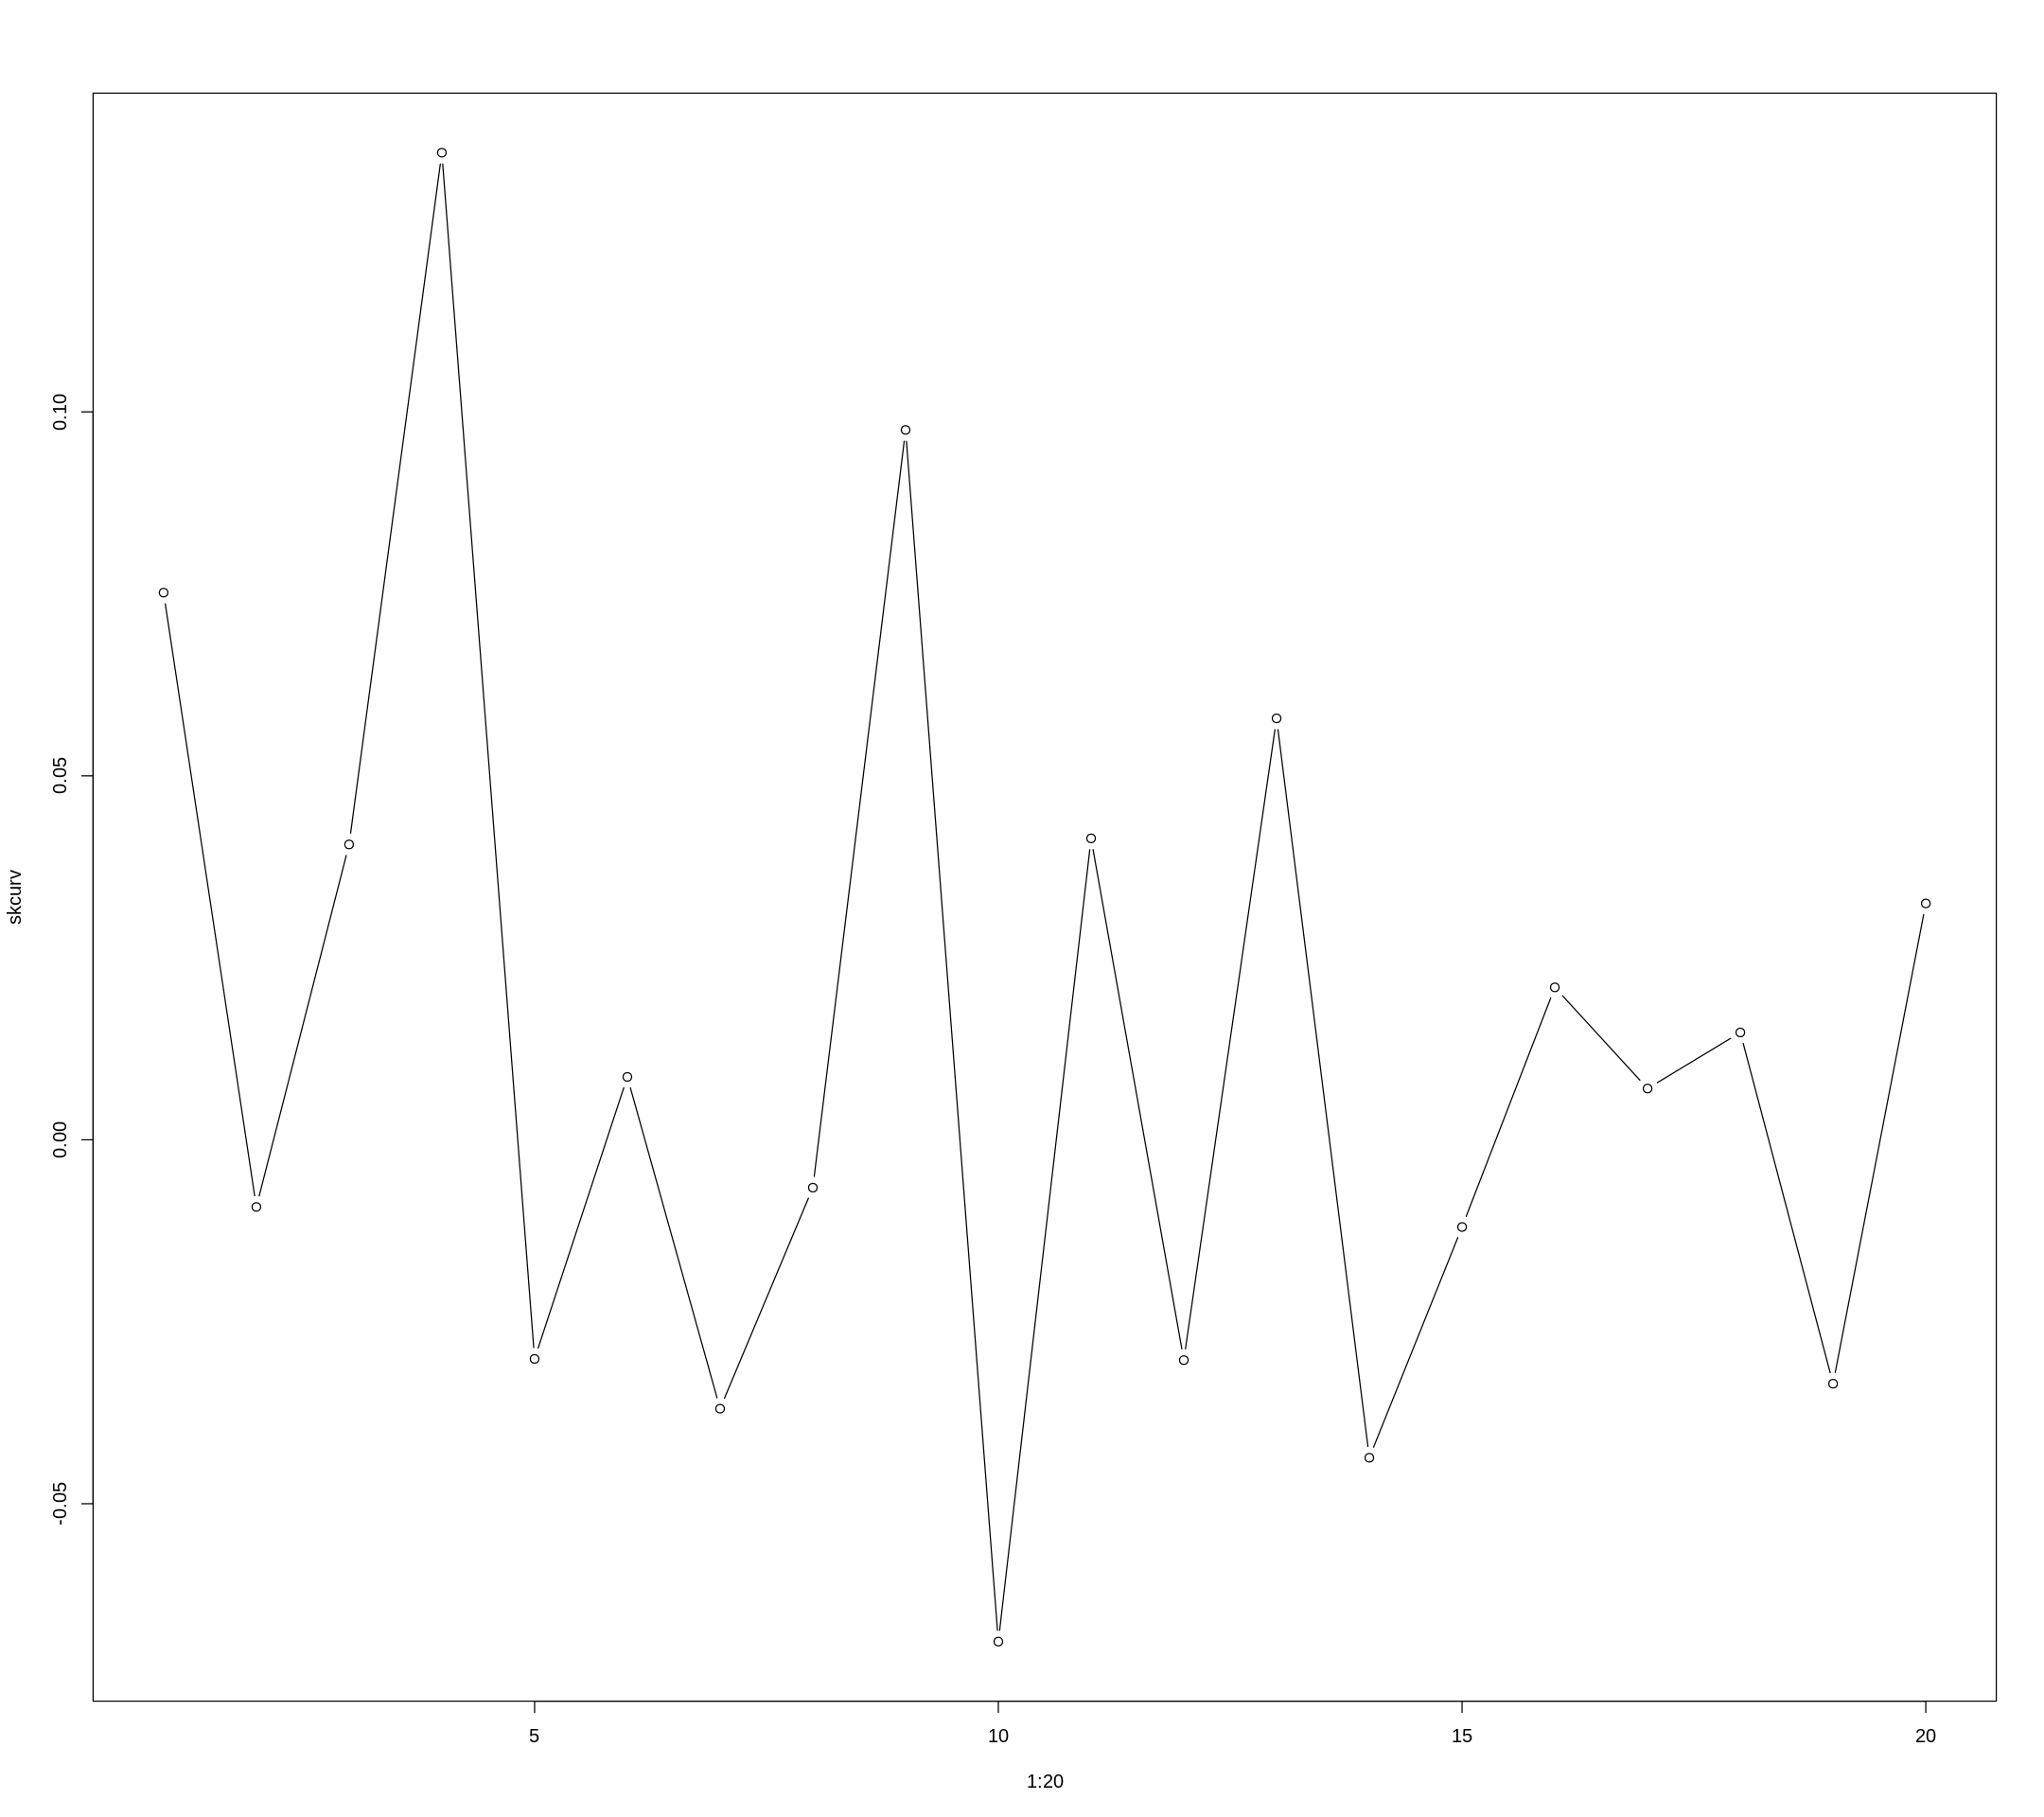

In [ ]:
eigenvalues_plot()

Performing again the semantically similar documents retrieval we obtain now better results. Now all the top 5 documents are semantically correlated with the query

In [ ]:
document_retrieval(query, 1, 5)

[1]   1 108 380 236 295


[1] "While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."                                                                                                                                                                                                                                                                     
[2] "Being 04:20 p.m. approximately, in the Nv. 1880, CX-781. Mr. Kevin helper of Jumbo 55, removed the drill rod that was in the drilling hole, instants that breaks the chain of subjection of the table of the drilling machine, sliding down achieving rubbing the index finger of the left hand, causing the injury."                                                                                                                                                                                                                                                                                                                                                                                                                          
[3] "In the area of ​​machine tools of the Maestranza the mechanic (injured) was operating the bench drill drilling a metal jacket of 25 \"x 26\" x 3/4 \"(lining) to install in the Skip; this moment he was accompanied by the mechanic Albino who manipulated the jacket and directed the maneuvers on the right side of the drill. Mr. Albino tells him to stop the drill to verify the depth of the drill, Luis lifts the Chuck and Albino pulls the iron and verifies that everything is fine and communicates that they will restart with the drilling of the other holes. that moment, the victim without apparent reason crosses his left arm with the drill on and is caught by the drill in his work clothes causing the injury described."
[4] "Inside mine during the diamond drilling of a positive 15 ° drill, in moments when the control tube was rescued with the fisherman, the winch cable breaks untimely developing a whiplash effect and impacting on the left hand of the drilling assistant causing the described injury. At the time of the accident the drilling assistant was on the platform at 1.0m from the frame and was using his Hycron-type safety gloves."                                                                                                                                                                                                                                                                                                             
[5] "When manipulating materials on the master drill truck, the operators decide to make space by moving a radiator, at that moment the driver of the truck is imprisoned the little finger of the left hand against the bar."

In order to demonstrate if a semantic correlation between query and class occurs in a ranked retrieval model like the one shown before, we need to select the number of the first k documents retrieved that we want to consider (R-precision).

So now the results of this ranked retrieval model, with a value of k=10, 50, 100,138 (the total number of class IV accidents in the dataset), are computed


In [ ]:
top_k <- sum(accidents == class)
query_vs_class <- semantic_correlation(class, 1, 5, top_k, query)
query_vs_class


III  IV 
  1   9 
accidents
  I  II III  IV   V  VI 
 43  95 106 138  28   1 

  I  II III  IV   V 
  6  28  44  55   5 


     class
query  No Yes
  No  190  83
  Yes  83  55

55 out of 138 class IV documents have been retrieved, so also the chi-square test confirms (with a confidence of 99.95%) that there is also semantic correlation (and not only syntactic one) between our query and the accident class

In [ ]:
chisq.test(query_vs_class, correct=FALSE)


	Pearson's Chi-squared test

data:  query_vs_class
X-squared = 3.672, df = 1, p-value = 0.05533


Now a visual verification of how the accident classes are distributed over the semantic search result is displayed.

As can be spotted, in the graph the IV accidents are represented in red, so a trend emerge, we can notice a major concentration of red documents in the first retrieved ones, this signify that the IV documents are the ones most similar with our query

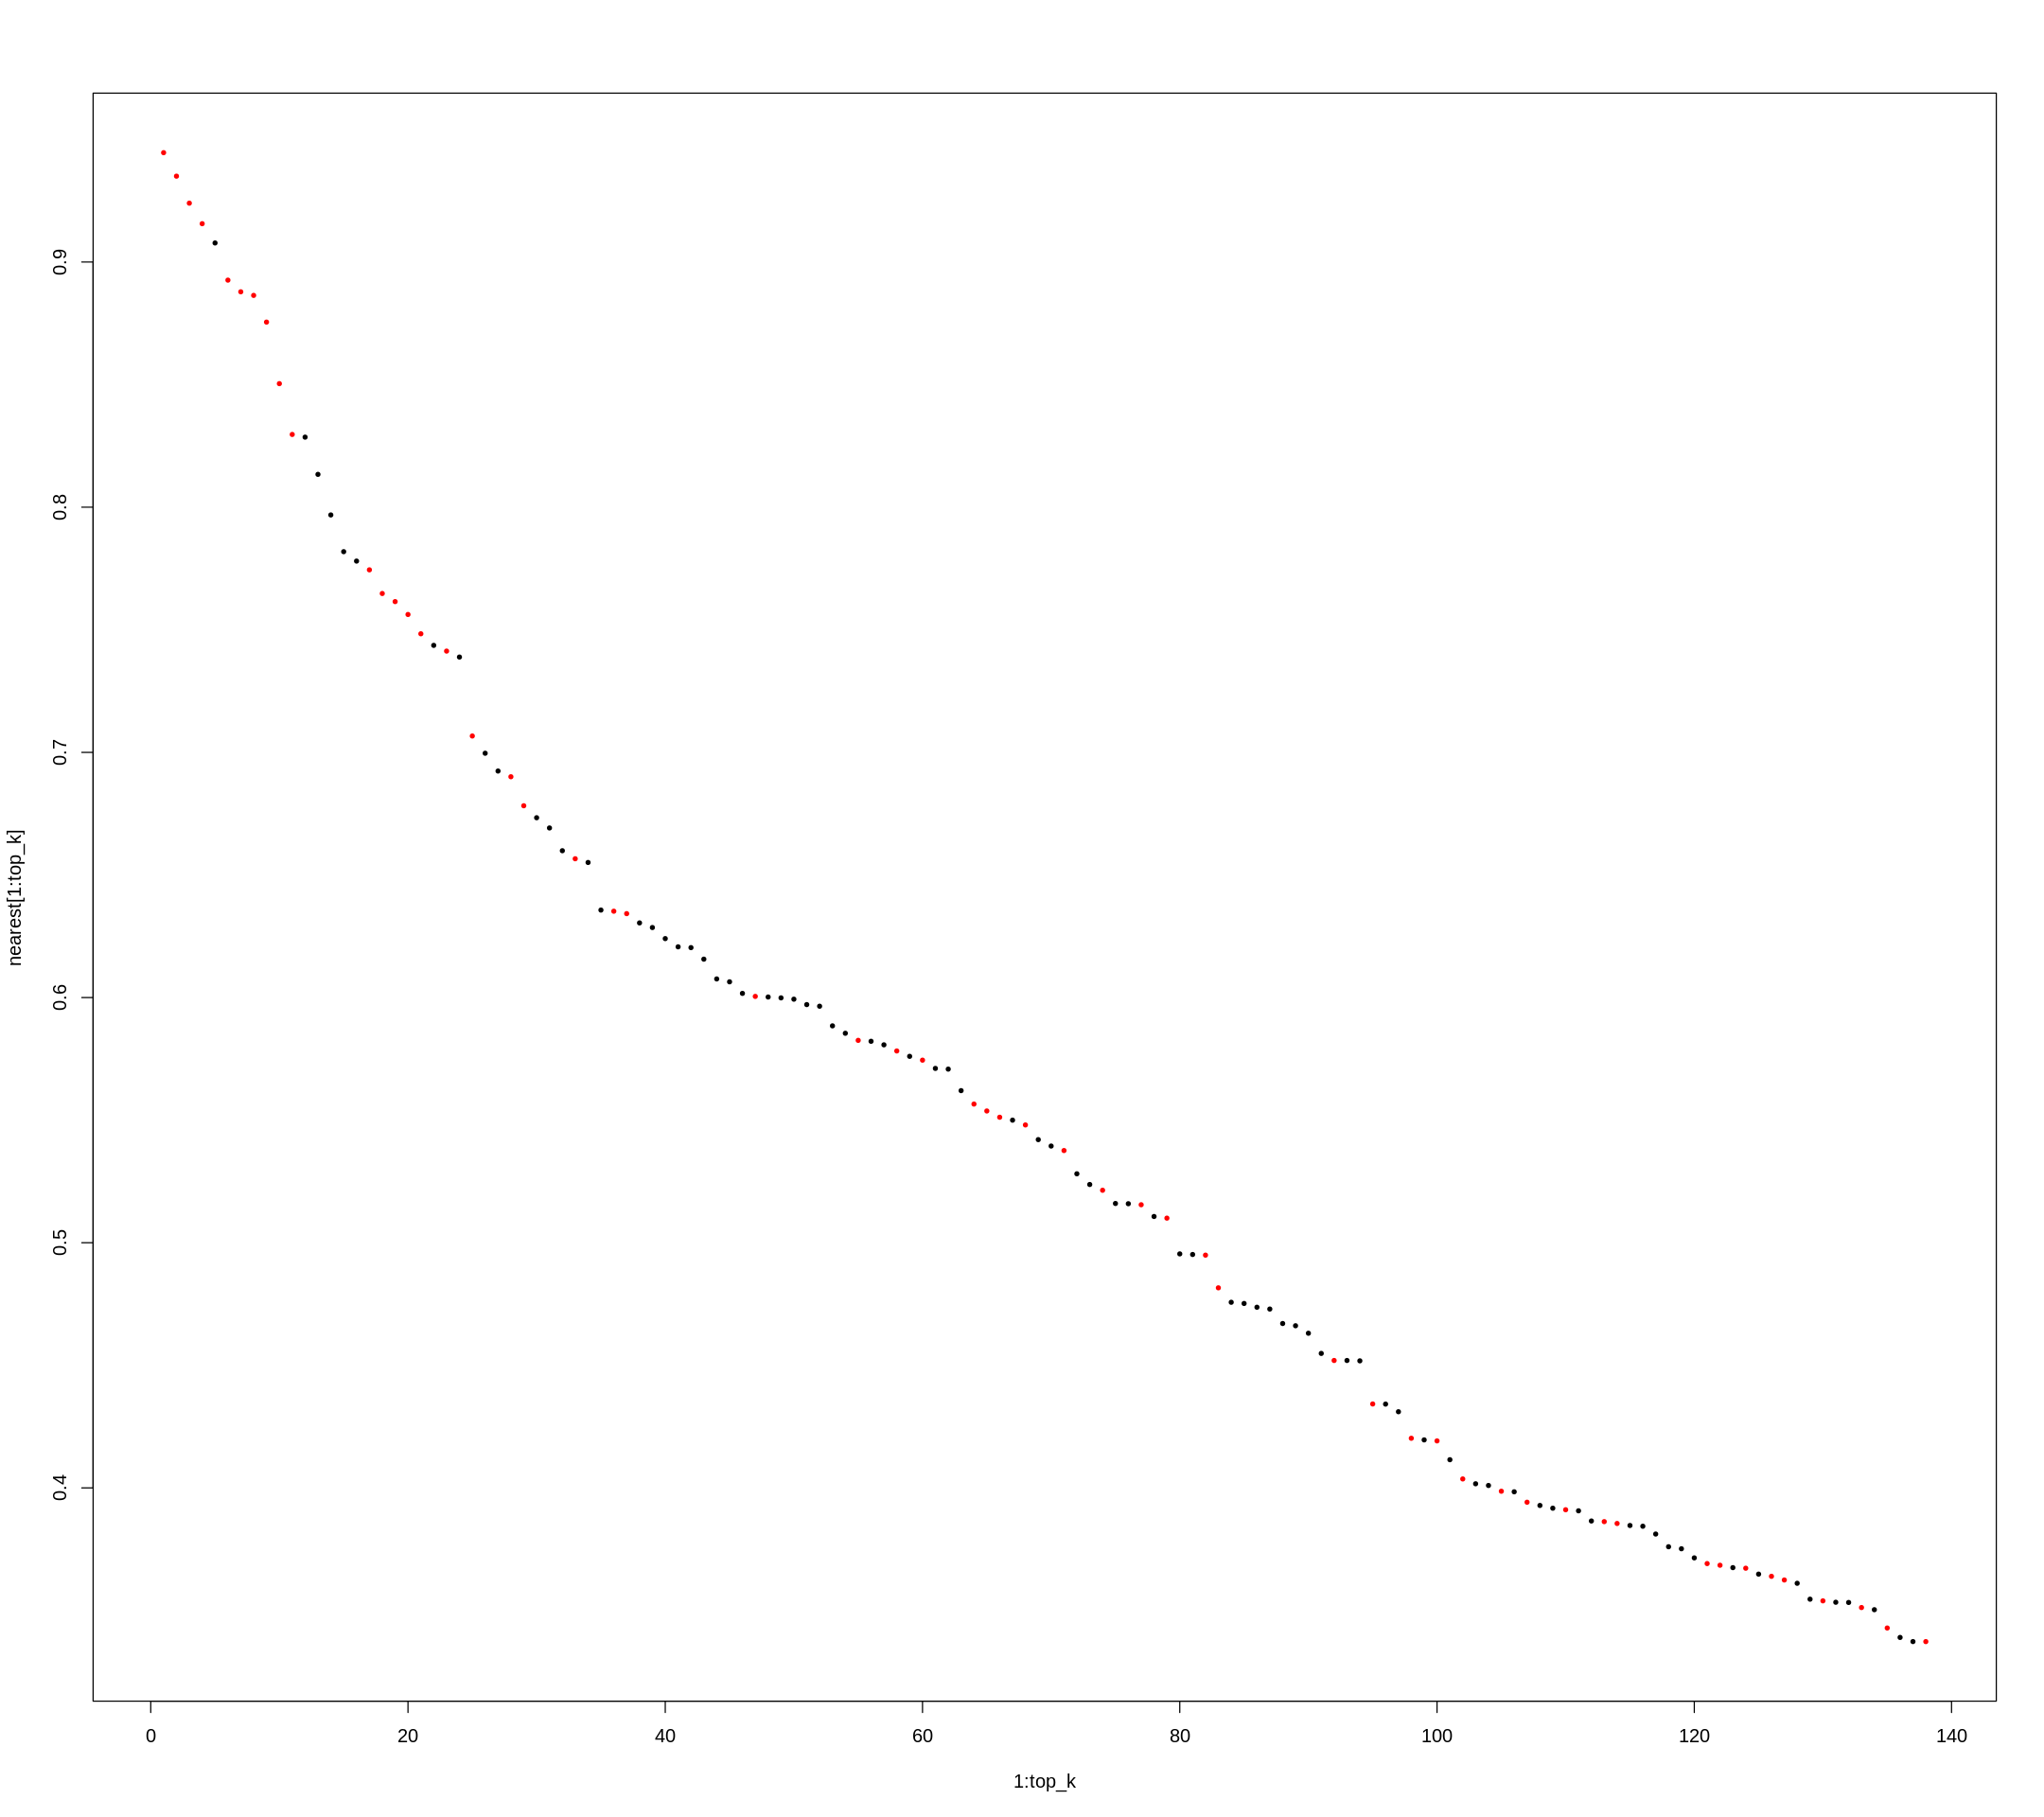

In [ ]:
semantic_search(1, 5, class)

Having obtained a positive result for our analysis in the previous stage a successive iteration of the method is performed, in order to spot other semantically significant words with respect to our current query.

In order to discard all the useless information, only terms with a cosine similarity over 0.90 with respect to the query are retrieved and then their norm is shown. Being two of the most promising results of this process not relevant in terms of our analysis, the remaining one i.e. **bar** is selected

In [ ]:
semantic_similarity(1, 5, 0.90, query)

 movement  drilling     drill       bar 
0.5839665 1.1168008 1.2811306 1.2923763 


Again the query embedding is shown in the LSA space and it's aligned with all the three terms that we are considering

[1] "First graph: terms, docs and query in the LSA space"


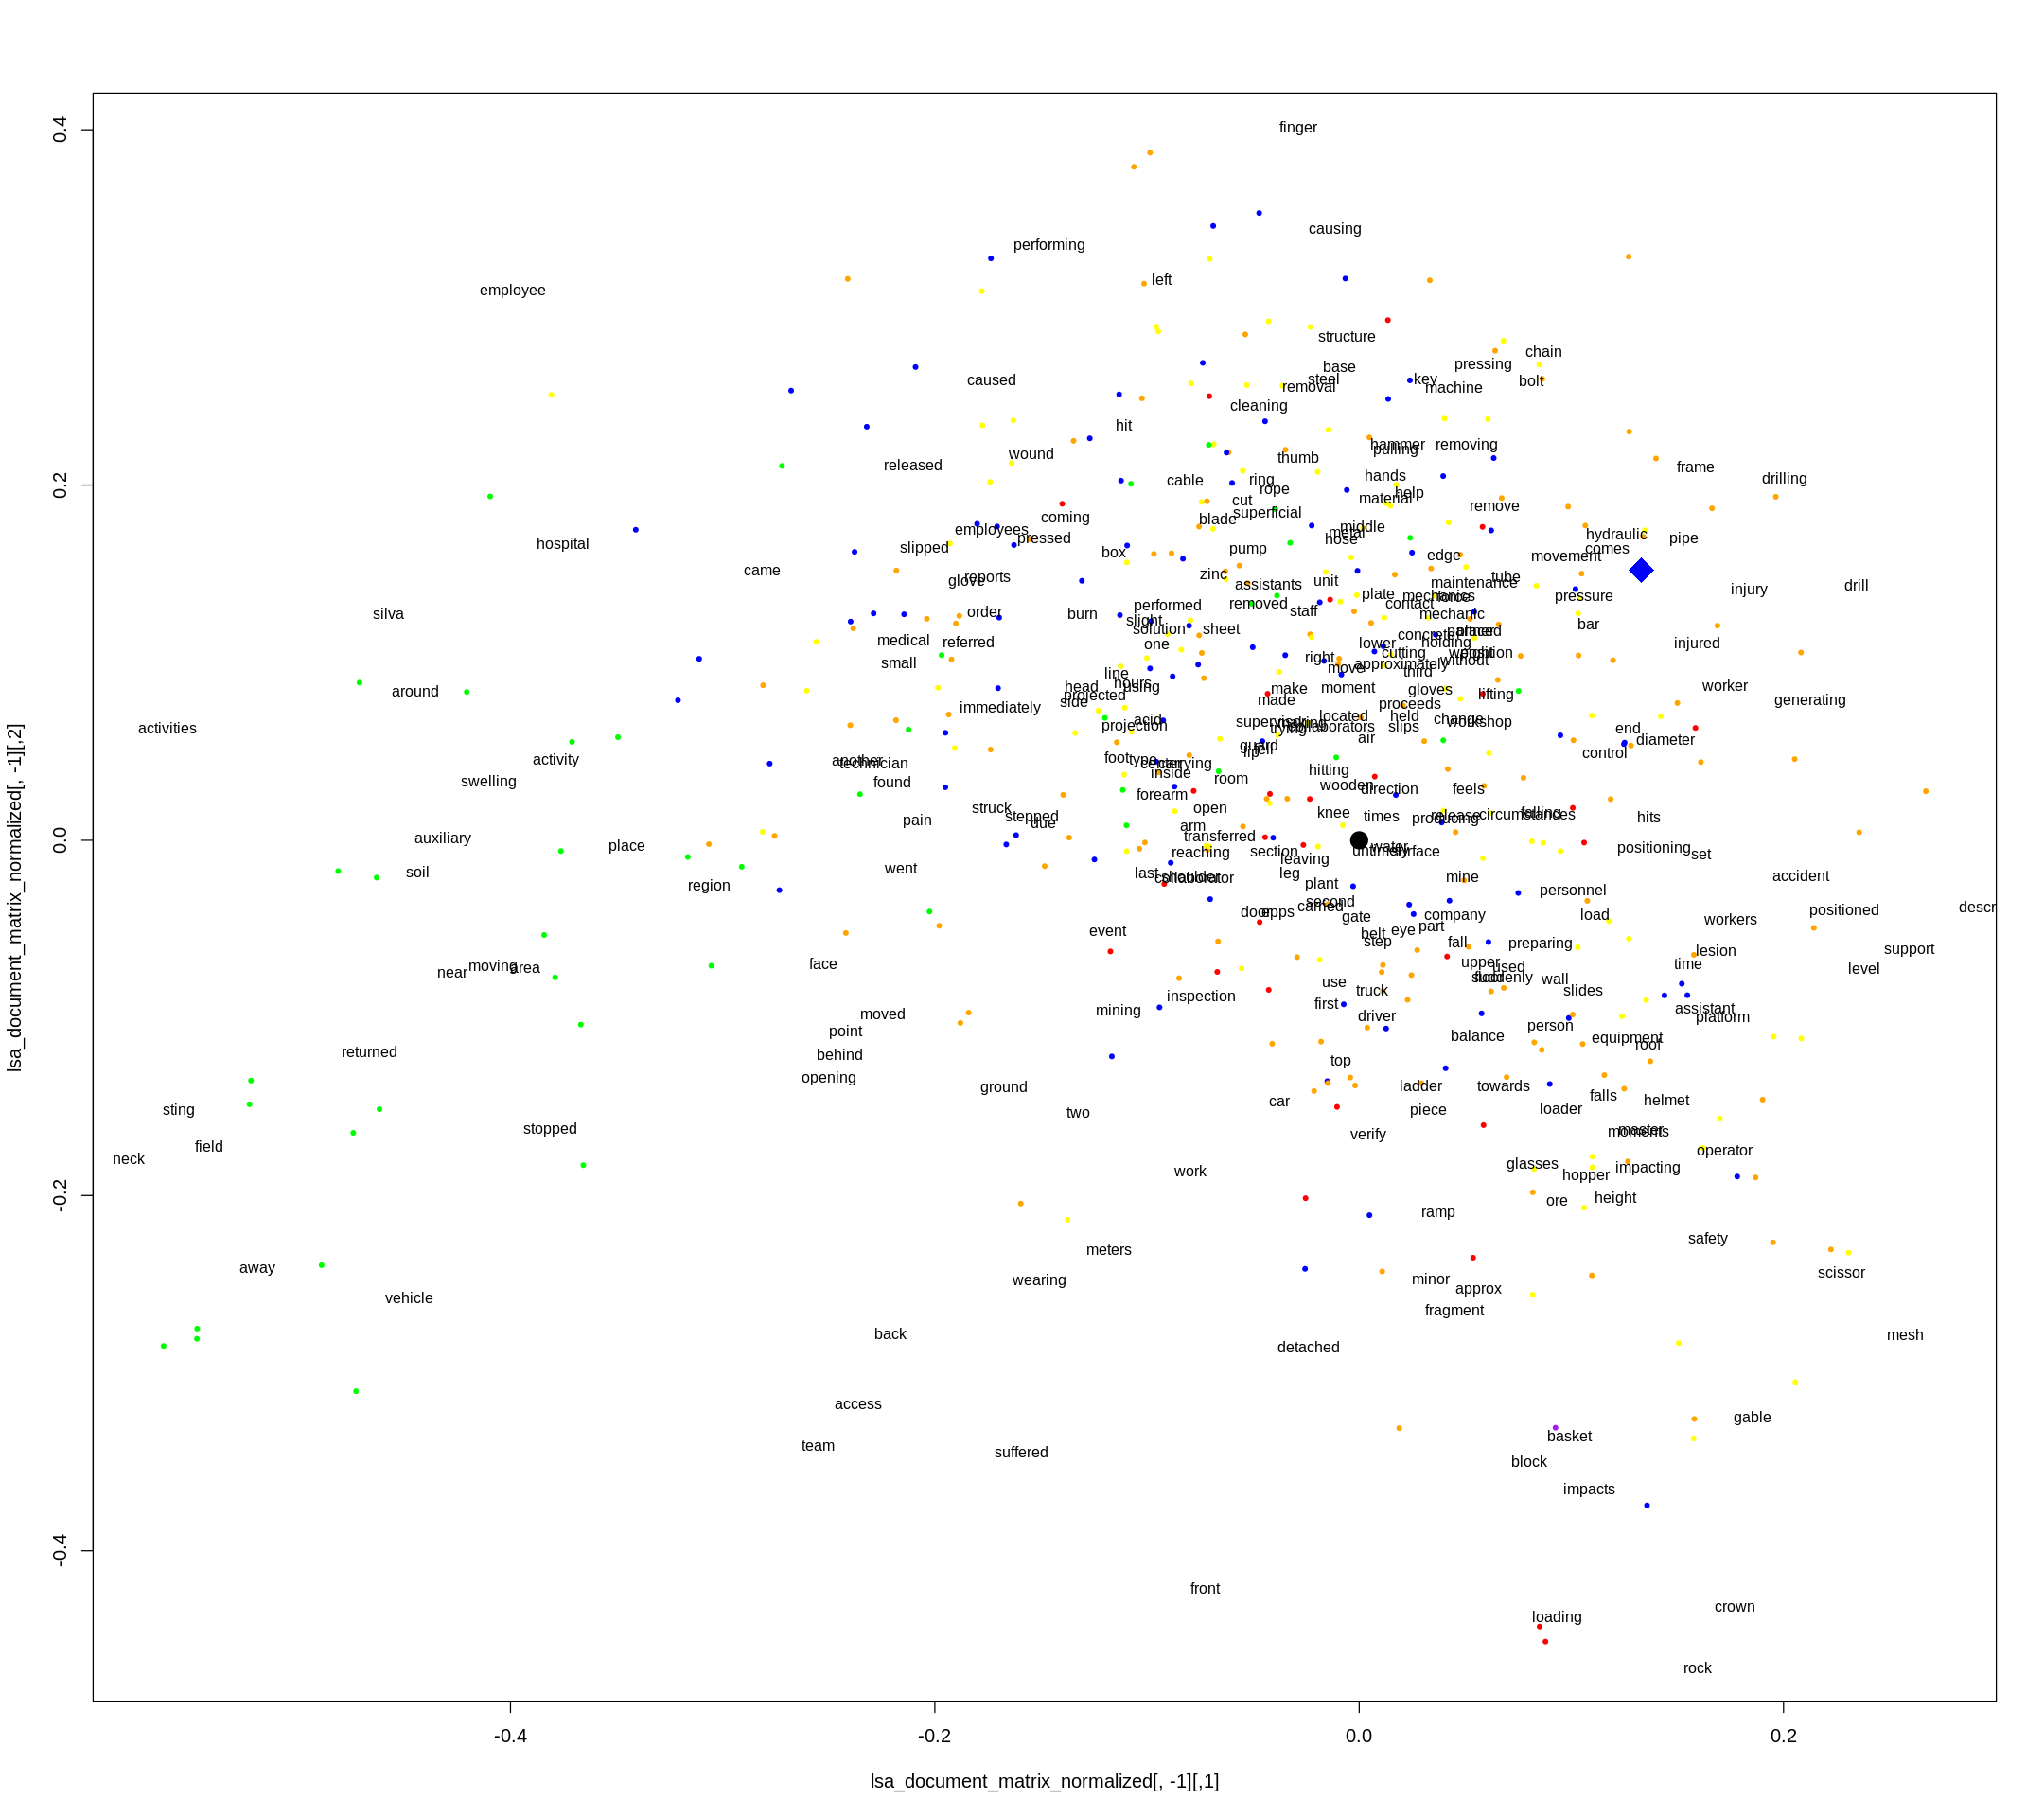

In [ ]:
word3 <- 'bar'
sentence <- paste(word1, word2, word3, sep =" ")
query_long <- query_embedding(sentence)

In [ ]:
document_retrieval(query_long, 1, 5)

[1]   1  22 271 380 108


[1] "While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."                                                                                                                                                                                                                                                                     
[2] "In the Raise chamber, when the operator and assistant removed the drilling bar from the 71R drilling machine - weight approx. 500 Kg - holding it at the top with a 2 TM stroke and assisted with jibs to move horizontally, the operator's jib on the bottom slides by moving the top of the drill bar causing the assistant's bar to enforce his assistant's hand between the bar and the piston of the equipment."                                                                                                                                                                                                                                                                                                                          
[3] "When performing the movement of the bar to make room and place a calibrator. Mr. Chuquillanqui pushes the bar with both hands turning it, being at that moment imprisoned the middle finger of the left hand against the other bar that was ahead."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
[4] "In the area of ​​machine tools of the Maestranza the mechanic (injured) was operating the bench drill drilling a metal jacket of 25 \"x 26\" x 3/4 \"(lining) to install in the Skip; this moment he was accompanied by the mechanic Albino who manipulated the jacket and directed the maneuvers on the right side of the drill. Mr. Albino tells him to stop the drill to verify the depth of the drill, Luis lifts the Chuck and Albino pulls the iron and verifies that everything is fine and communicates that they will restart with the drilling of the other holes. that moment, the victim without apparent reason crosses his left arm with the drill on and is caught by the drill in his work clothes causing the injury described."
[5] "Being 04:20 p.m. approximately, in the Nv. 1880, CX-781. Mr. Kevin helper of Jumbo 55, removed the drill rod that was in the drilling hole, instants that breaks the chain of subjection of the table of the drilling machine, sliding down achieving rubbing the index finger of the left hand, causing the injury."

Now we compute how many documents are in common in the document retrieval process for the original query **drilling workshop** and the more specific one **drilling workshop bar**.

Being 123 out of 138 this means that the result is basically the same also adding this new information, but this hypotesis need to be further investigated in the following cells


In [ ]:
length(intersect(top(cosines(lsa_document_matrix[,1:5], query[1:5]), top_k), top(cosines(lsa_document_matrix[,1:5], query_long[1:5]), top_k)))

[1] 123

In [ ]:
query_long_vs_IV <- semantic_correlation(class, 1, 5, top_k, query_long)
query_long_vs_IV


III  IV 
  1   9 
accidents
  I  II III  IV   V  VI 
 43  95 106 138  28   1 

  I  II III  IV   V 
  8  26  45  53   6 


     class
query  No Yes
  No  188  85
  Yes  85  53

In [ ]:
chisq.test(query_long_vs_IV, correct = FALSE)


	Pearson's Chi-squared test

data:  query_long_vs_IV
X-squared = 2.1724, df = 1, p-value = 0.1405


In this case, having obtained a worse result in terms of chi-square value with the longer query (i.e. **drilling workshop bar**), the iterative process of query refinement has been stopped, considering informative enough the previous query (i.e. **drilling workshop**)for our purposes.

##Conclusion
In the end we can conclude that the majority of the accidents whose potential level is IV (high severity) are strictly related to the drilling workshop activities; no further hypotesis can be inferred over accidents in drilling workshop related to drilling bars/rods

###Another interesting analysis direction
This method can be used to easily detect not only severe accidents, but also mild ones. An example starting from the visual inspection cell could be the term **mesh** which is in a zone of unusual level III accidents distribution.

Testing the synctactic correlation of this word with class III accidents yields a promising result for further investigations in this direction

In [ ]:
word <- 'mesh'
class <- 'III'
test_one_word (word, class, lsa_term_matrix)


	Pearson's Chi-squared test

data:  word_vs_class
X-squared = 4.5726, df = 1, p-value = 0.03249

[1] "List of the top 16 most correlated words to the one selected:"
  scissor  operator  suddenly    helmet      used    person   company     upper 
0.9999848 0.9995631 0.9995431 0.9993898 0.9992464 0.9992206 0.9983150 0.9982640 
     fall    master     falls   moments     floor equipment impacting    safety 
0.9981181 0.9980973 0.9976133 0.9975087 0.9972094 0.9949191 0.9937356 0.9933532 
